In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps

# stel de logger in om alleen foutmeldingen naar het scherm te printen
ps.set_log_level("ERROR")

# print de versies van belangrijke Python packages voor pastas
# ps.show_versions(numba=True)

%config InlineBackend.figure_format = 'retina'

/Applications/anaconda3/envs/mude/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (

# Calibration of a time series model

**Table of contents**

- [Introduction](#introduction)
- [Effect of the length of the time series (or calibration period)](#effect-of-the-length-of-the-time-series-(or-calibration-period))
- [The noise model](#the-noise-model)
- [Effect of a noise model](#effect-of-a-noise-model)
- [Effect of the noise model on the estimation and reliability of parameter values](#effect-of-the-noise-model-on-the-estimation-and-reliability-of-parameter-values)
- [Effect of an error in the measured groundwater recharge](#effect-of-an-error-in-the-measured-groundwater-recharge)
- [Effect of the measurement frequency on the performance of the AR1 noise model](#effect-of-the-measurement-frequency-on-the-performance-of-the-ar1-noise-model)


## Introduction

Calibration of a time series model refers to finding the model parameters such that the groundwater heads simulated by the model match the observed heads as closely as possible. The parameters found through this process are called the optimal parameters. The most commonly used method to find these optimal parameters is the minimization of the sum of squared differences between the observed and modeled heads, also known as the least squares method. The sum of squares is a non-linear function of the model parameters. To find the optimal parameters, a search method is used.

There are several different search methods available to find the optimal model parameters. Each method is based on a different search algorithm, but the core idea is the same: the model is run multiple times with different values for the parameters. Based on the results (and the corresponding sum of squares), the algorithm determines the next set of parameter values that might result in a lower sum of squares. This continues until the algorithm decides that the best parameter set has been found. The efficiency of the search algorithm depends on how many model runs are needed to find the optimal parameters. Naturally, it is recommended to choose initial parameter values that are as close as possible to the optimal values. Most software packages include strategies to make smart initial guesses for the model parameters, sometimes using characteristics of the input series. In some cases, the modeler may have system-specific knowledge that helps choose better initial values.

Most commonly used algorithms search for the optimal parameters by gradually adjusting them so that the sum of squares decreases with each step. This creates a direct path from the initial values to the optimal values, where the sum of squares gets smaller at every step. However, this can lead the algorithm to get stuck in a local minimum. It's possible that along the path from the initial to the optimal parameters, the sum of squares temporarily increases before decreasing again. Advanced search algorithms exist that also explore parameter sets that initially result in a higher sum of squares, with the goal of eventually finding the global minimum. Of course, this requires significantly more computation time.


To illustrate, the figure below shows the progression of the six parameters and the objective function (in this case, the root mean squared error for the noise) for each run during the search for the optimal parameters. The same well is used in the following example, where it will be described in more detail. For each iteration in the search process, the model is run multiple times—at least once per parameter. This explains why the parameter values change step by step, either increasing or decreasing. In total, the model was run nearly 100 times to find the optimal parameters.

In [2]:
ho = pd.read_csv('data/B58C0698001_1.csv', skiprows=15, index_col=2, parse_dates=True).iloc[:, 4].loc['1990':'2009']/100


rain_raw = pd.read_csv('data/neerslaggeg_HEIBLOEM-L_967.txt', skiprows=23, index_col=0, parse_dates=True)
rain_raw.index = pd.to_datetime(rain_raw["YYYYMMDD"], format="%Y%m%d")
rain = rain_raw["   RD"].loc["1980":"2009"].astype(float)/10000

evap = pd.read_csv('data/etmgeg_380.txt', skiprows=47, index_col=1, parse_dates=True)[' EV24'].loc['1980':'2009'].astype(float)/10000
ho

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.Columns (5,6,7,8,9,10,13,15,20,21,22,23,24,27,29,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.

1990-01-14    27.76
1990-01-28    28.00
1990-02-14    28.14
1990-03-13    28.31
1990-03-27    28.20
              ...  
2009-10-28    27.30
2009-11-14    27.64
2009-11-28    27.86
2009-12-14    28.03
2009-12-28    28.11
Name: Stand (cm t.o.v. MV), Length: 426, dtype: float64

In [3]:
ml = ps.Model(ho.loc['1990':])
rm = ps.RechargeModel(rain, evap, ps.Gamma(), name='recharge')
ml.add_stressmodel(rm)
ml.add_noisemodel(ps.ArNoiseModel())
track = ps.TrackSolve(ml)
ml.solve(report=False, callback=track.track_solve)

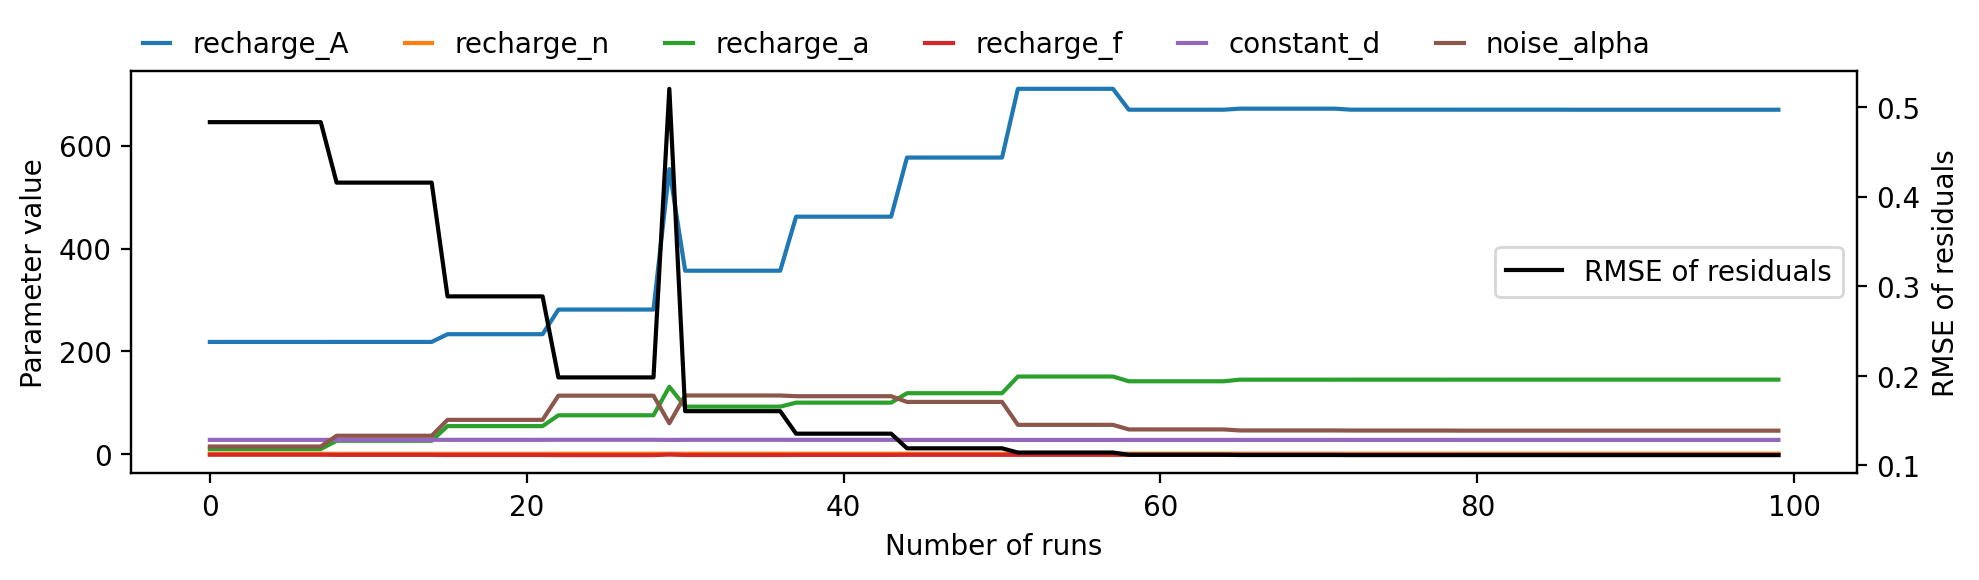

In [4]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
track.parameters.plot(ax=ax)
plt.xlabel('Number of runs')
plt.ylabel('Parameter value')
ax2 = ax.twinx()
ax2.plot(track.rmse_res, color='k', ls='-', label='RMSE of residuals')
plt.ylabel('RMSE of residuals')
ax.legend(loc=(0, 1), frameon=False,
          ncol=6, handlelength=1)
ax2.legend(loc='right')
plt.tight_layout()

## Effect of the length of the time series (or calibration period)

The effect of the length of the calibration period on the results of a time series model is illustrated using measurements from well B58C0698 in the town of Swartbroek near Weert. Data from the period 1990–2010 is used, during which measurements were taken approximately twice per month. The rainfall time series comes from the Heibloem rain station, and the potential evaporation data is from the Maastricht weather station.

A time series model was built using rainfall and potential evaporation as explanatory series, with a scaled Gamma function used as the response function. The entire dataset is used to calibrate the model. The model fits the data well, as shown in the figure below. The block response and step response functions are also shown. The memory of the block response function is slightly more than 2.5 years. After a rainfall event on the first day, the groundwater level rises fairly quickly, but it takes about 2.5 years to return to the pre-rainfall level. The peak of the block response function is just above 4, which means that if 1 mm of rain falls in a single day, the groundwater head will eventually rise by 4 mm. This corresponds to an effective porosity (phreatic storage) of 1 / 4 = 0.25, which is a reasonable value. The step response eventually reaches a value slightly above 650. This means that if it rains continuously at 1 mm/day starting from the first day, the groundwater head will eventually rise by a little more than 650 mm. This corresponds to parameter $A$ of the Gamma response function (see [Notebook on model structure](%%)).


In [40]:
ho = pd.read_csv('data/B58C0698001_1.csv', skiprows=15, index_col=2, parse_dates=True).iloc[:, 4].loc['1990':'2009']/100

rain_raw = pd.read_csv('data/neerslaggeg_HEIBLOEM-L_967.txt', skiprows=23, index_col=0, parse_dates=True)
rain_raw.index = pd.to_datetime(rain_raw["YYYYMMDD"], format="%Y%m%d")
rain = rain_raw["   RD"].loc["1980":"2009"].astype(float)/10000

evap = pd.read_csv('data/etmgeg_380.txt', skiprows=47, index_col=1, parse_dates=True)[' EV24'].loc['1980':'2009'].astype(float)/10000

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.Columns (5,6,7,8,9,10,13,15,20,21,22,23,24,27,29,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.

In [41]:
ml = ps.Model(ho.loc['1990':])
rm = ps.RechargeModel(rain, evap, ps.Gamma(), name='recharge')
ml.add_stressmodel(rm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(report=False)

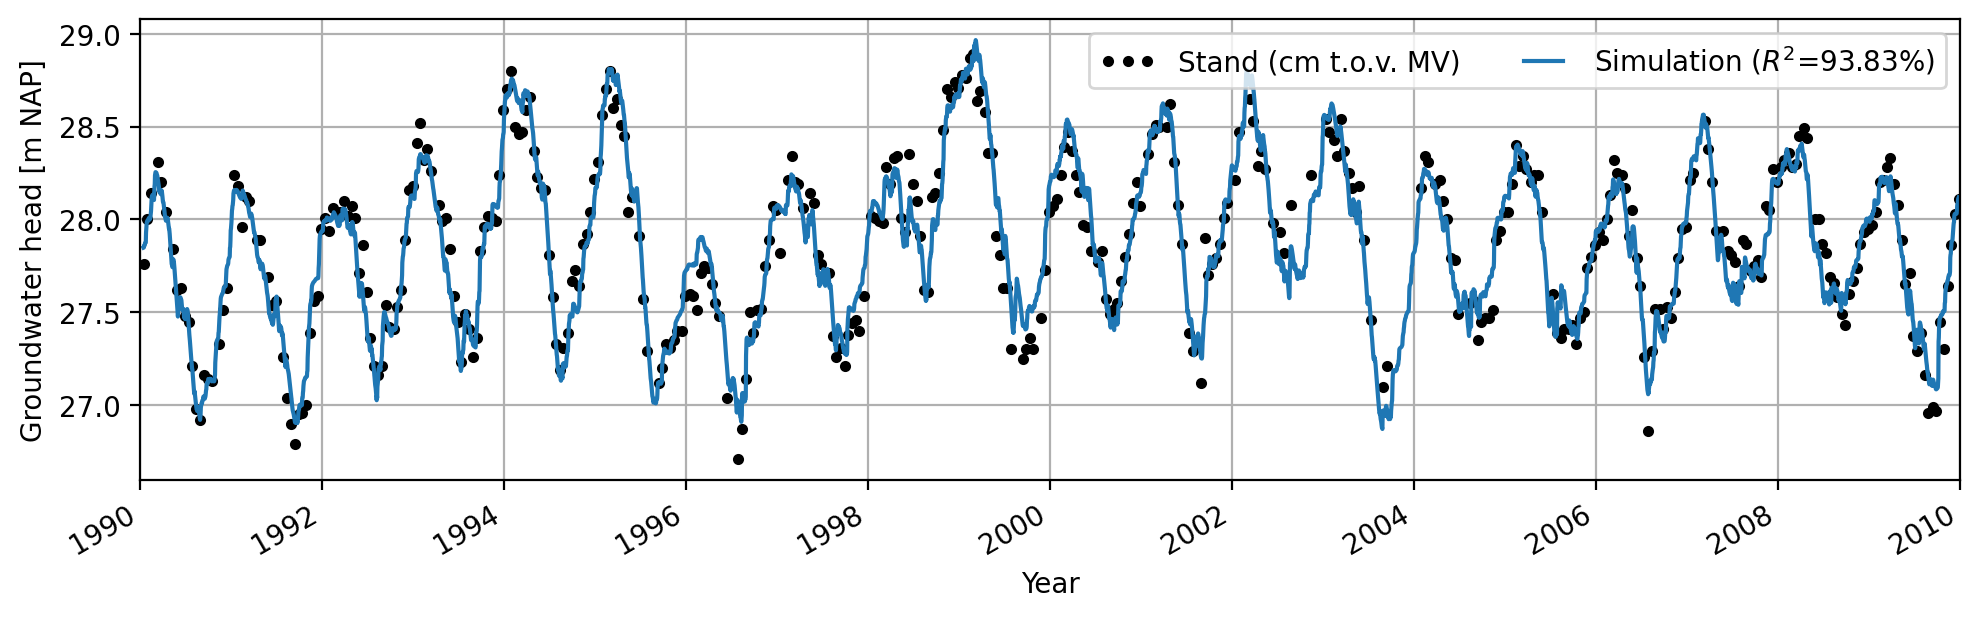

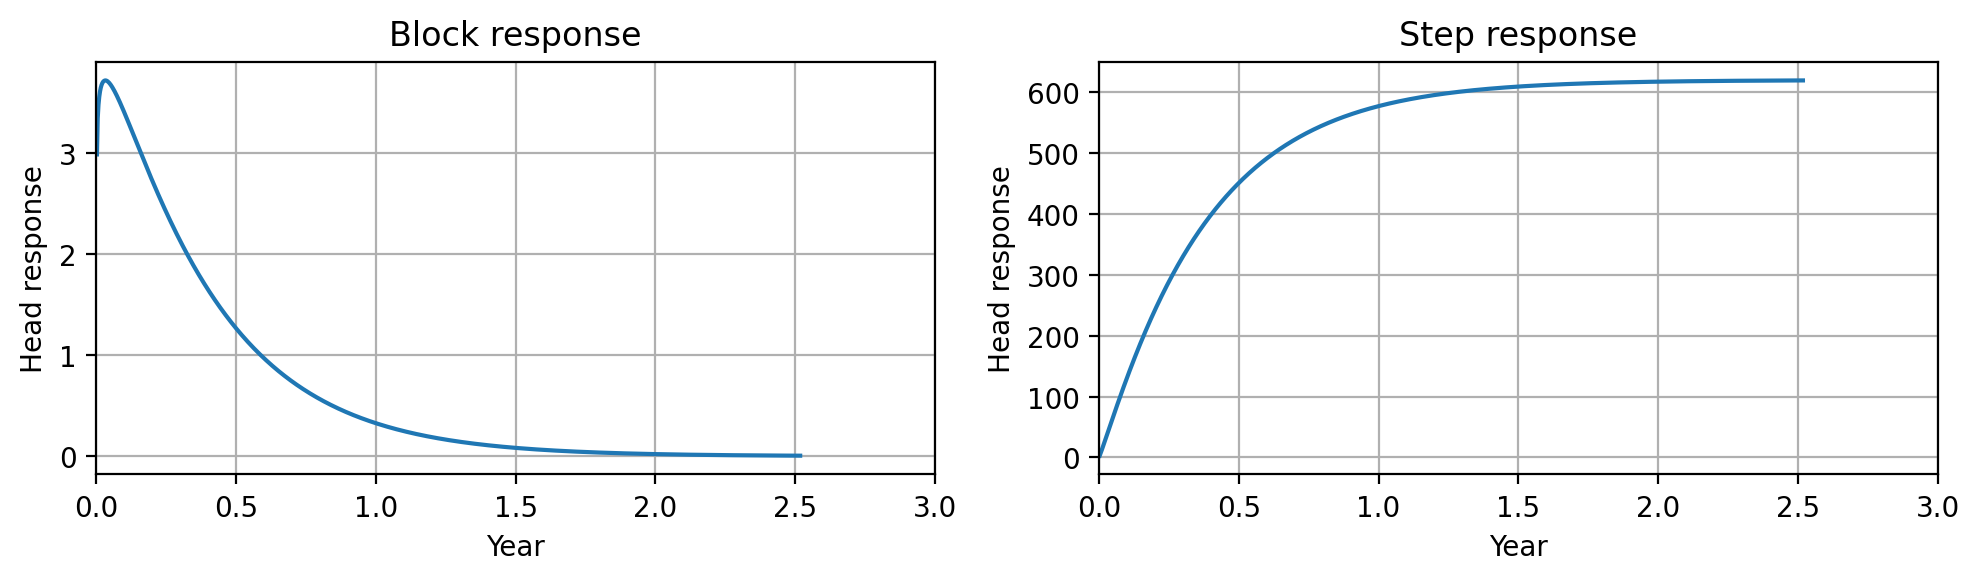

In [42]:
ml = ps.Model(ho.loc['1990':])
rm = ps.RechargeModel(rain, evap, ps.Gamma(), name='recharge')
ml.add_stressmodel(rm)
ml.solve(report=False)

ml.plot(figsize=(10, 3))
ho.name = "B58C0698001"
plt.xlabel('Year')
plt.ylabel("Groundwater head [m NAP]")
plt.grid()
plt.xlim('1990', '2010')

block = ml.get_block_response('recharge')
step = ml.get_step_response('recharge')
step.index /= 365
block.index /= 365
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
block.plot(ax=ax[0], ylabel='Head response',
           title='Block response', xlabel='Year', xlim=(0, 3))
ax[0].grid()
step.plot(ax=ax[1], ylabel='Head response',
          title='Step response', xlabel='Year', xlim=(0, 3))
ax[1].grid()
plt.tight_layout()


In the model above, 20 years of data are used to calibrate the model. But what happens if a shorter time series is used? Will the same response function still be found? To investigate this, the model is calibrated using 1 year of data (1990–1991), then 2 years (1990–1992), and so on up to 20 years (1990–2010). For each calibration, the value of parameter $A$ (the final value of the step response) is stored. 

In the figure below, the calibrated value of $A$ is plotted against the length of the calibration period, including the 95% confidence interval. The figure shows that if the calibration period is long enough, the results converge to approximately the same value. In this case, a calibration period of 5 years (1990–1995) is sufficient. That’s about twice the memory of the block response function, which is a reasonable rule of thumb for this case.

In [8]:
Alist = []
years = np.arange(1991, 2011, 1)
for endyear in years:
    ml = ps.Model(ho.loc['1990':])
    rm = ps.RechargeModel(rain, evap, ps.Gamma(), name='recharge')
    ml.add_stressmodel(rm)
    ml.add_noisemodel(ps.ArNoiseModel())
    ml.solve(tmin='1990', tmax=str(endyear), report=False)
    Alist.append(ml.parameters.loc['recharge_A', ['optimal', 'stderr']])
Alist = np.array(Alist)

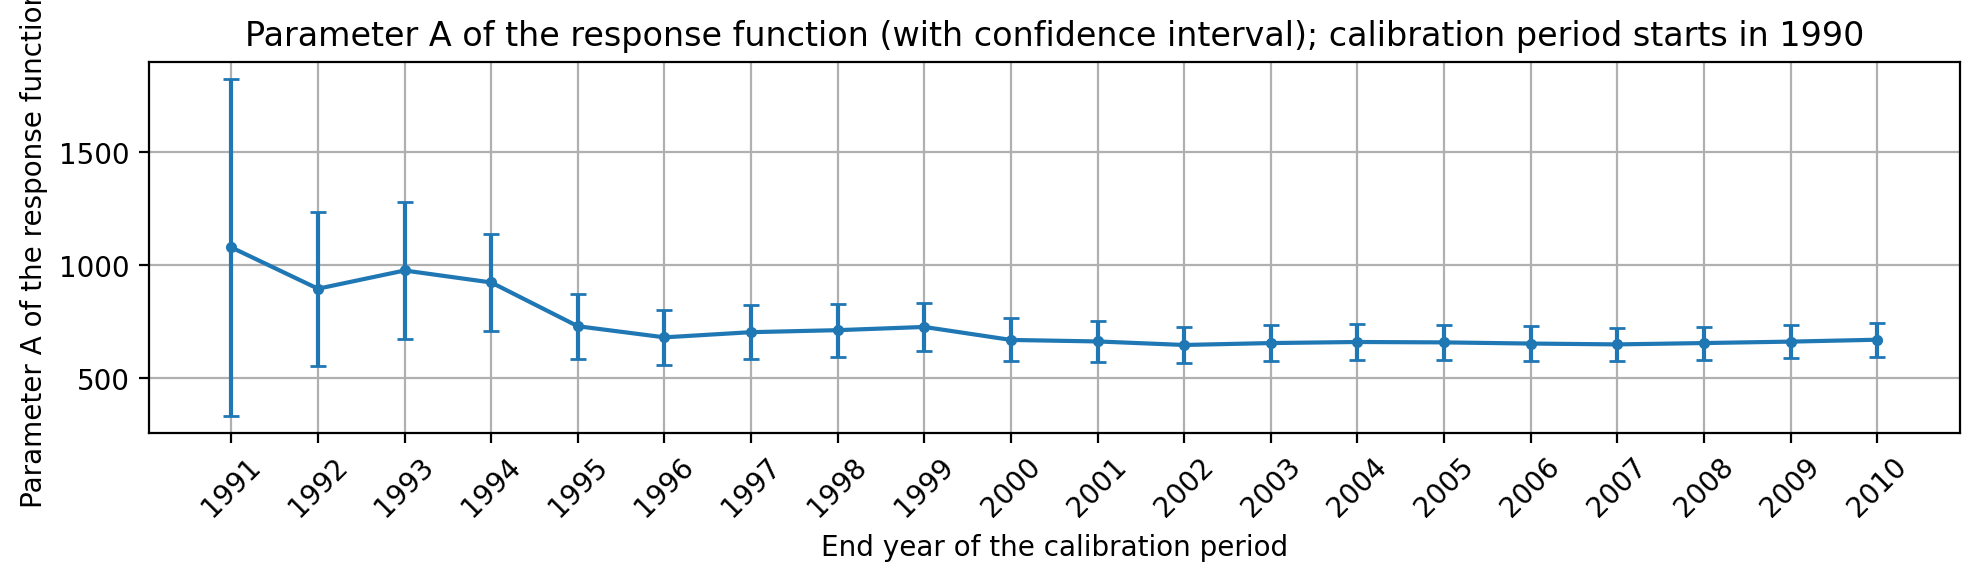

In [9]:
plt.figure(figsize=(10, 3))
plt.errorbar(years, Alist[:, 0], marker='.', yerr=2 * Alist[:, 1], capsize=3)
plt.xticks(years, rotation=45)
plt.grid()
plt.xlabel('End year of the calibration period')
plt.ylabel('Parameter A of the response function')
plt.title('Parameter A of the response function (with confidence interval); calibration period starts in 1990')
plt.tight_layout()

With a shorter calibration period, a value of $A$ that is too high is estimated in this example, and the confidence interval is also too narrow. The value of $A$ found using a longer calibration period ($A \approx 650$) lies far outside the confidence interval of the value found with a calibration period of only 1 or a few years. 

The value obtained from, for example, a 3-year calibration period may provide a good fit for those three years, but beyond that, the simulated groundwater heads will mostly lie above the measured heads, as shown below. 

If a different 3-year period is chosen for calibration, the model can still perform reasonably well — as shown below for the period 1993–1996 — but that can only be assessed if data is also available for the validation period.


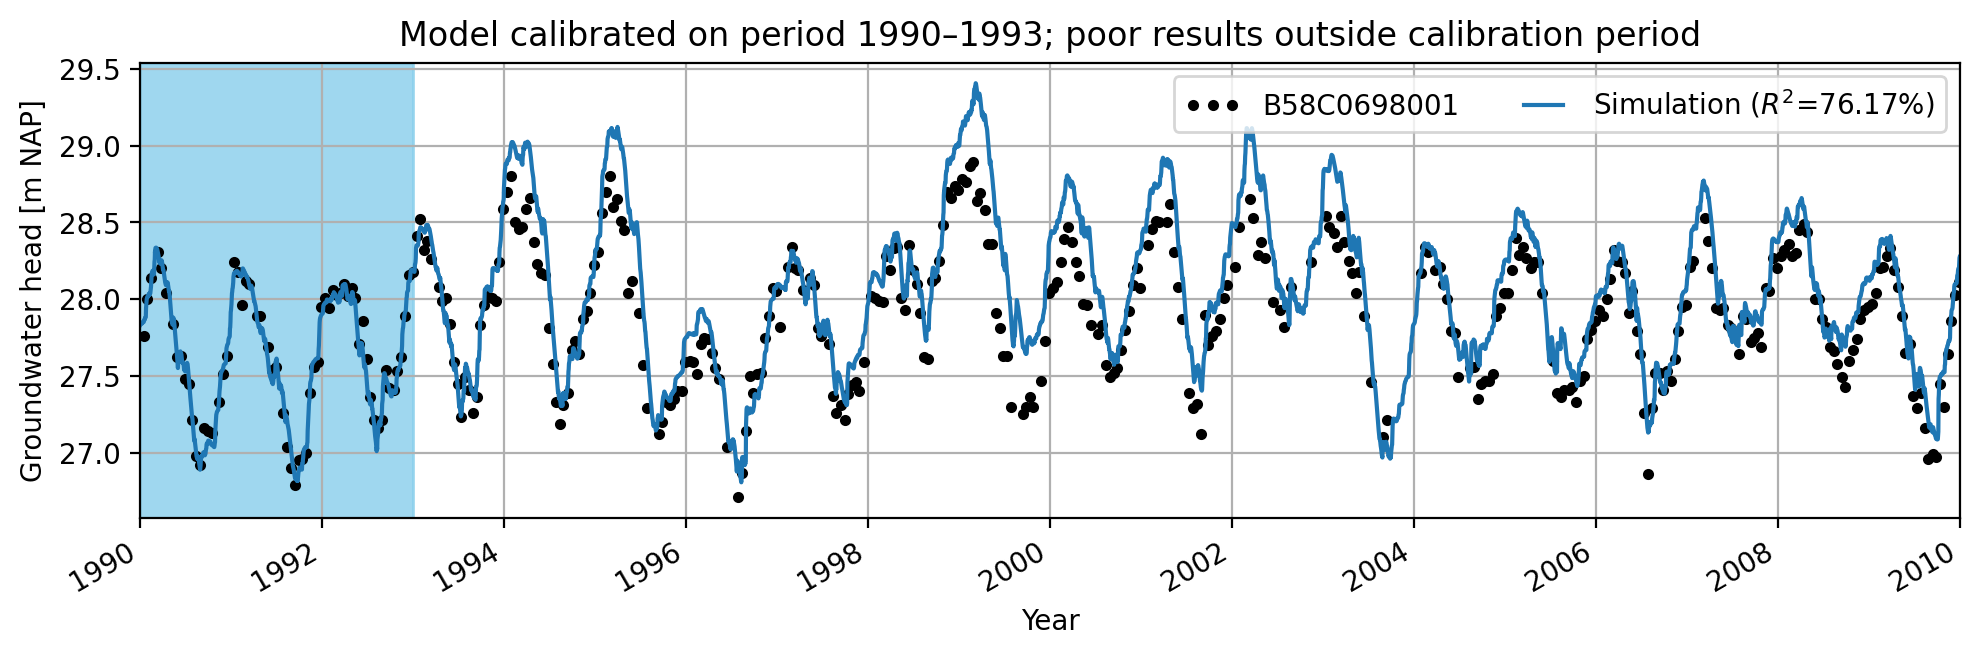

In [10]:
ho.name = "B58C0698001"
ml = ps.Model(ho.loc['1990':])
rm = ps.RechargeModel(rain, evap, ps.Gamma(), name='recharge')
ml.add_stressmodel(rm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(tmin='1990', tmax='1993', report=False)
ml.plot(tmin='1990', tmax='2010', figsize=(10, 3))
plt.xlabel('Year')
plt.ylabel("Groundwater head [m NAP]")
plt.grid()
plt.title('Model calibrated on period 1990–1993; poor results outside calibration period')
plt.axvspan('1990', '1993', alpha=0.8, color='skyblue')

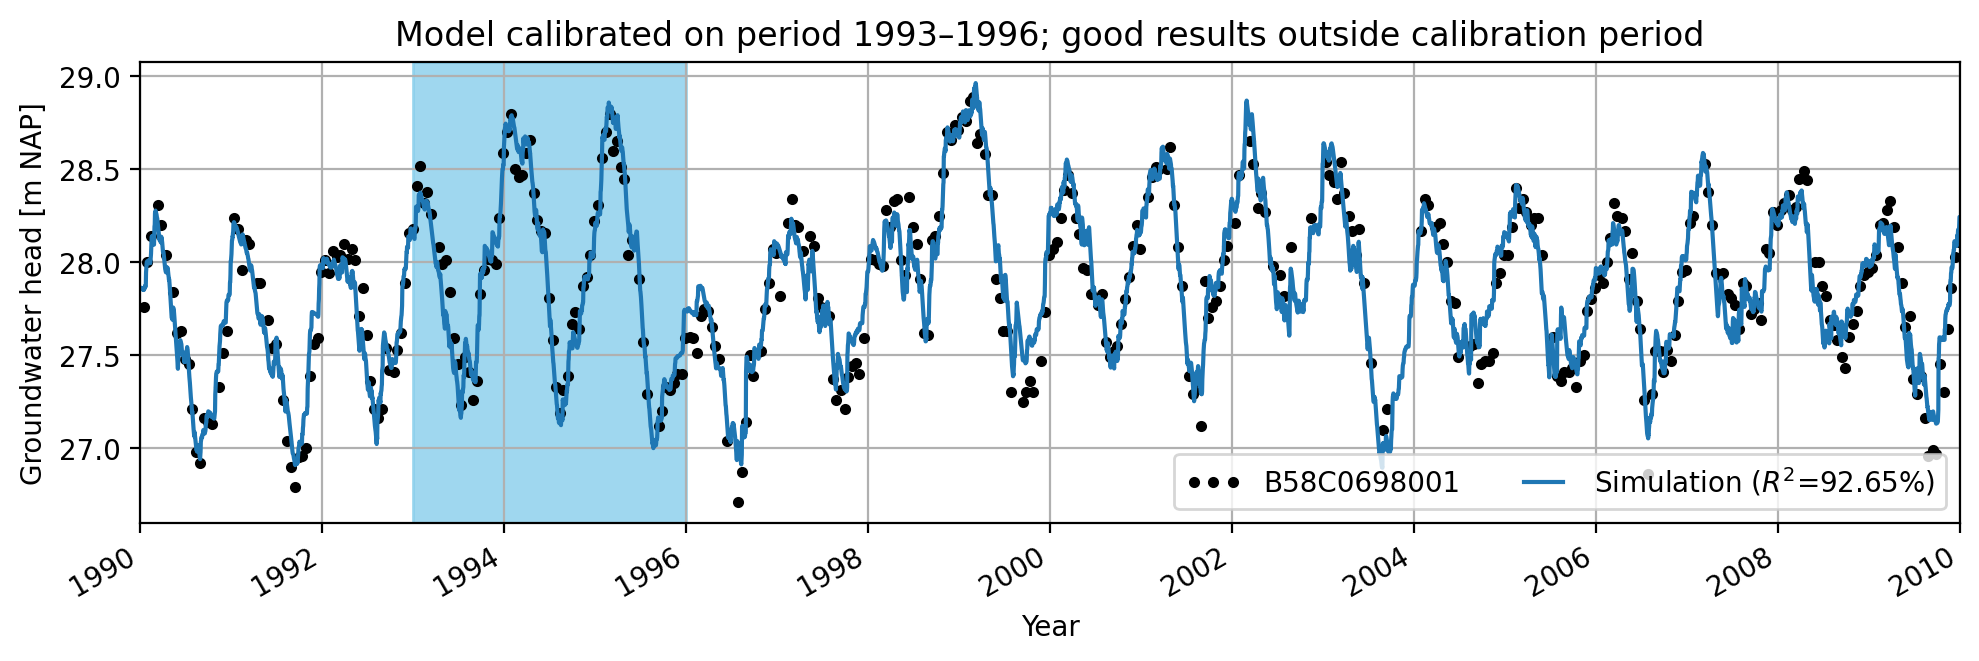

In [11]:
ho.name = "B58C0698001"

ml = ps.Model(ho.loc['1990':])
rm = ps.RechargeModel(rain, evap, ps.Gamma(), name='recharge')
ml.add_stressmodel(rm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(tmin='1993', tmax='1996', report=False)

ml.plot(tmin='1990', tmax='2010', figsize=(10, 3))
plt.xlabel('Year')
plt.ylabel("Groundwater head [m NAP]")
plt.grid()
plt.title('Model calibrated on period 1993–1996; good results outside calibration period')
plt.axvspan('1993', '1996', alpha=0.8, color='skyblue')

Intuitively, it makes sense that the calibration period should be at least several times the memory of the system. However, it is difficult to define a fixed rule for the required length of the calibration period. As illustrated above, 3 years may be sufficient for this series, but the outcome depends on which 3 years are chosen — and that’s clearly not ideal in practice.

[Van der Spek and Bakker (2017)](#references) investigated the minimum length of a calibration period after which the uncertainty in predicted groundwater heads no longer decreases. They analyzed 18 time series with approximately two measurements per month and response times ranging from 60 to 1200 days, but could not find a clear relationship between the system's memory (response time) and the required calibration period length.

With a 20-year calibration period, they found that the average 95% prediction interval for groundwater heads was about 50% of the total variation in groundwater head (i.e., the difference between the highest and lowest observed levels), while the model's confidence interval was about 10% of the total variation. With a calibration period of only 10 years, the results depended strongly on which 10-year period was used — for some periods, the confidence interval was much larger than for others. With a calibration period of only 5 years, the confidence interval was almost always large.

The conclusion from [Van der Spek and Bakker (2017)](#references) is that the model's reliability increases with a longer calibration period, but does not significantly improve once the calibration period exceeds 20 years.


## The noise model

A noise model can be used to ensure that the remaining differences between the model and the observations meet certain statistical assumptions, allowing statistical statements to be made using the model (for example: what is the probability that the groundwater head exceeds a certain threshold?). In the previous model, a noise model was also used—although not discussed in detail—so that the residuals approximately satisfied statistical tests and confidence intervals for the parameters could be estimated.

The differences between the measured and modeled groundwater heads (the residuals) are almost always temporally correlated. Simply put: if the model overestimates the groundwater head today, there's a good chance it will overestimate it again next week. This is easy to explain. For instance, the rainfall data may come from a weather station located 20 km away from the observation well. If it rained at the station but not at the well, the model may simulate a groundwater head that is too high. And since it takes some time for the water level to drop after a rain event, the model may continue to overestimate the head for several days, weeks, or even months. Fortunately, the opposite can also occur: it might rain at the well but not at the station, balancing things out over time. An error in the rainfall input is just one possible cause of discrepancies between the model and measurements. Other causes include measurement errors, unobserved changes, or non-linearity in the system.

Autocorrelation in the residuals becomes a problem when the model is used to make statistical inferences. To do so reliably, the residuals must satisfy certain statistical assumptions—one of the most important being that they are not autocorrelated. A noise model can be added to a time series model to transform autocorrelated residuals into uncorrelated noise.

The simplest noise model is the so-called first-order autoregressive model, or AR(1) model. In this model, the residual $\varepsilon(t)$ at time $t$ is equal to a factor $\rho$ times the residual at time $t - \Delta t$ plus a random (uncorrelated) error $n(t)$:

$$
\varepsilon(t) = \rho \varepsilon(t - \Delta t) + n(t)
$$

If the time interval $\Delta t$ between two residuals varies, then the factor $\rho$ can be expressed as a function of $\Delta t$, decreasing as the time step increases:

$$
\varepsilon(t) = \text{e}^{-\Delta t / \alpha} \varepsilon(t - \Delta t) + n(t)
$$

Here, $\alpha$ is a parameter that describes how quickly the correlation between residuals decays with increasing $\Delta t$. The correlation becomes negligible when $\Delta t > 3\alpha$ (since $e^{-3} \approx 0.05$).

In the example below, synthetic time series are generated and analyzed to demonstrate that in time series models without a noise model, parameter estimates may still be accurate, but the confidence intervals are underestimated.


## Effect of a noise model

To generate the synthetic series, daily groundwater recharge is calculated as the measured rainfall minus the measured potential evaporation from the previous example (so this is actual rainfall and evaporation data). The response function for groundwater recharge is an exponential function with parameters $A = 600$ and $a = 150$ days. The base level is set to $d = 25$ meters.

A synthetic groundwater head time series is then simulated using the same observation timestamps as in the previous example. This generated synthetic time series contains no noise or errors. A time series model applied to this synthetic groundwater head series, using an exponential response function, is able to recover the parameters $A$, $a$, and $d$ almost exactly, as shown below.

In [12]:
recharge = rain - evap
A = 600
a = 150
d = 25

In [13]:
ml = ps.Model(ho)  # only the timestamps at which measurements were taken are used
rm = ps.StressModel(recharge, ps.Exponential(), name='recharge', settings = 'prec')
ml.add_stressmodel(rm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.set_parameter('recharge_A', initial=A)
ml.set_parameter('recharge_a', initial=a)
ml.set_parameter('constant_d', initial=d)
hsynthetic_no_error = ml.simulate().loc[ho.index]

In [14]:
ml = ps.Model(hsynthetic_no_error)
rm = ps.StressModel(recharge, ps.Exponential(), name='recharge', settings = 'prec')
ml.add_stressmodel(rm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve()

Fit report Simulation              Fit Statistics
nfev    10                     EVP         100.00
nobs    426                    R2            1.00
noise   True                   RMSE          0.00
tmin    1990-01-14 00:00:00    AICc     -22004.40
tmax    2009-12-28 00:00:00    BIC      -21988.28
freq    D                      Obj           0.00
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (4 optimized)
               optimal     initial  vary
recharge_A   600.00000  218.329585  True
recharge_a   150.00000   10.000000  True
constant_d    25.00000   25.272783  True
noise_alpha  218.63993   15.000000  True

Warnings! (1)
Response tmax for 'recharge' > than warmup period.


To illustrate how the noise model works, a residual (an error) is added to the synthetic groundwater head series. The residual at time $t$, $\epsilon(t)$, is correlated with the residual at the previous measurement time $t - \Delta t$, according to the formula given earlier.

The noise term $n(t)$ is drawn from a normal distribution with a mean of zero and a standard deviation $\sigma_n$. The stronger the correlation between residuals, the larger the standard deviation of the residuals becomes. The standard deviation $\sigma_r$ of the residuals can be calculated from the standard deviation $\sigma_n$ of the noise as follows:

$$\sigma_r = \sigma_n / \sqrt{1 - \text{e}^{-2\Delta t / \alpha}}$$

The residuals are generated using $\sigma_n = 0.1$ m and $\alpha = 50$ days. The standard deviation of the residuals, $\sigma_r$, for a time step of 14 days is then equal to:

In [15]:
sigma_n = 0.1
alpha = 50
sigma_r = sigma_n / np.sqrt(1 - np.exp(-2 * 14 / alpha))
print(f'sigma_r = {sigma_r:.2f} m')

sigma_r = 0.15 m


The synthetic groundwater head series now contains a correlated error, just like in reality. We will now first create a time series model of the synthetic series *without* a noise model.

The time series model appears to provide a good fit, and the estimated parameters reasonably match the parameters used to generate the synthetic series. However, note that the value of $a$ used to generate the synthetic series ($a = 150$ days) does not fall within the estimated confidence interval of the estimated value of $a$.

The diagnostic test, however, shows that there is autocorrelation in the residuals, so formally, the estimated confidence interval is not valid. We will investigate this further.


Estimated 95% confidence interval for a: 127.27 - 147.64


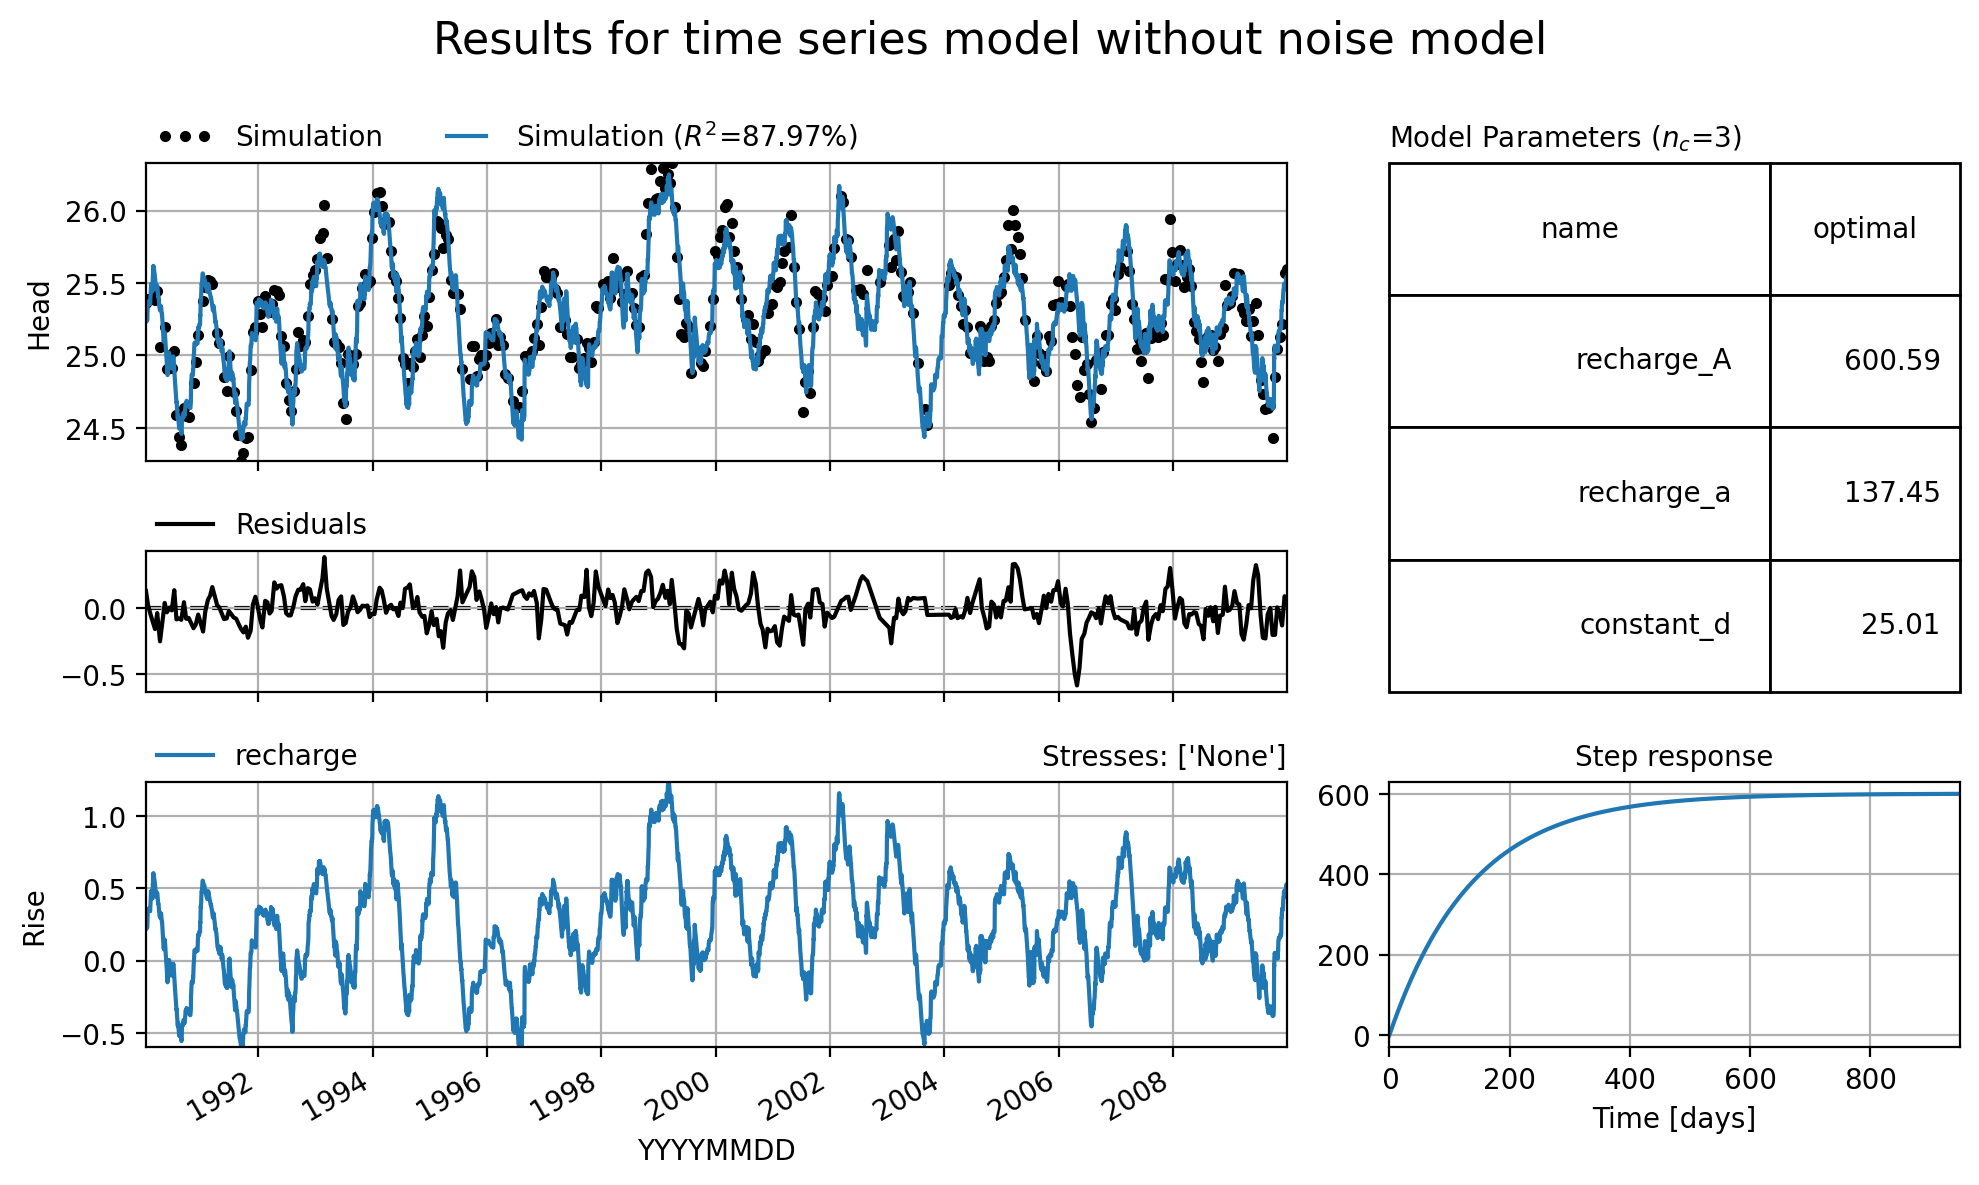

In [16]:
delt = (ho.index[1:] - ho.index[:-1]).values / pd.Timedelta("1d")
np.random.seed(1)
noise = sigma_n * np.random.randn(len(ho))
residuals = np.zeros_like(noise)
residuals[0] = noise[0]
for i in range(1, len(ho)):
    residuals[i] = np.exp(-delt[i - 1] / alpha) * residuals[i - 1] + noise[i]
hsynthetic = hsynthetic_no_error + residuals

ml = ps.Model(hsynthetic)
rm = ps.StressModel(recharge, ps.Exponential(), name='recharge', settings = 'prec')
ml.add_stressmodel(rm)
ml.solve(report=False)
ml.plots.results(figsize=(10, 6))
fig = plt.gcf()
fig.suptitle('Results for time series model without noise model', fontsize=16)
plt.tight_layout()
a_min = ml.parameters.loc['recharge_a', 'optimal'] - \
    1.96 * ml.parameters.loc['recharge_a', 'stderr']
a_max = ml.parameters.loc['recharge_a', 'optimal'] + \
    1.96 * ml.parameters.loc['recharge_a', 'stderr']
print(f'Estimated 95% confidence interval for a: {a_min:.2f} - {a_max:.2f}')

The figure layout has changed to tight

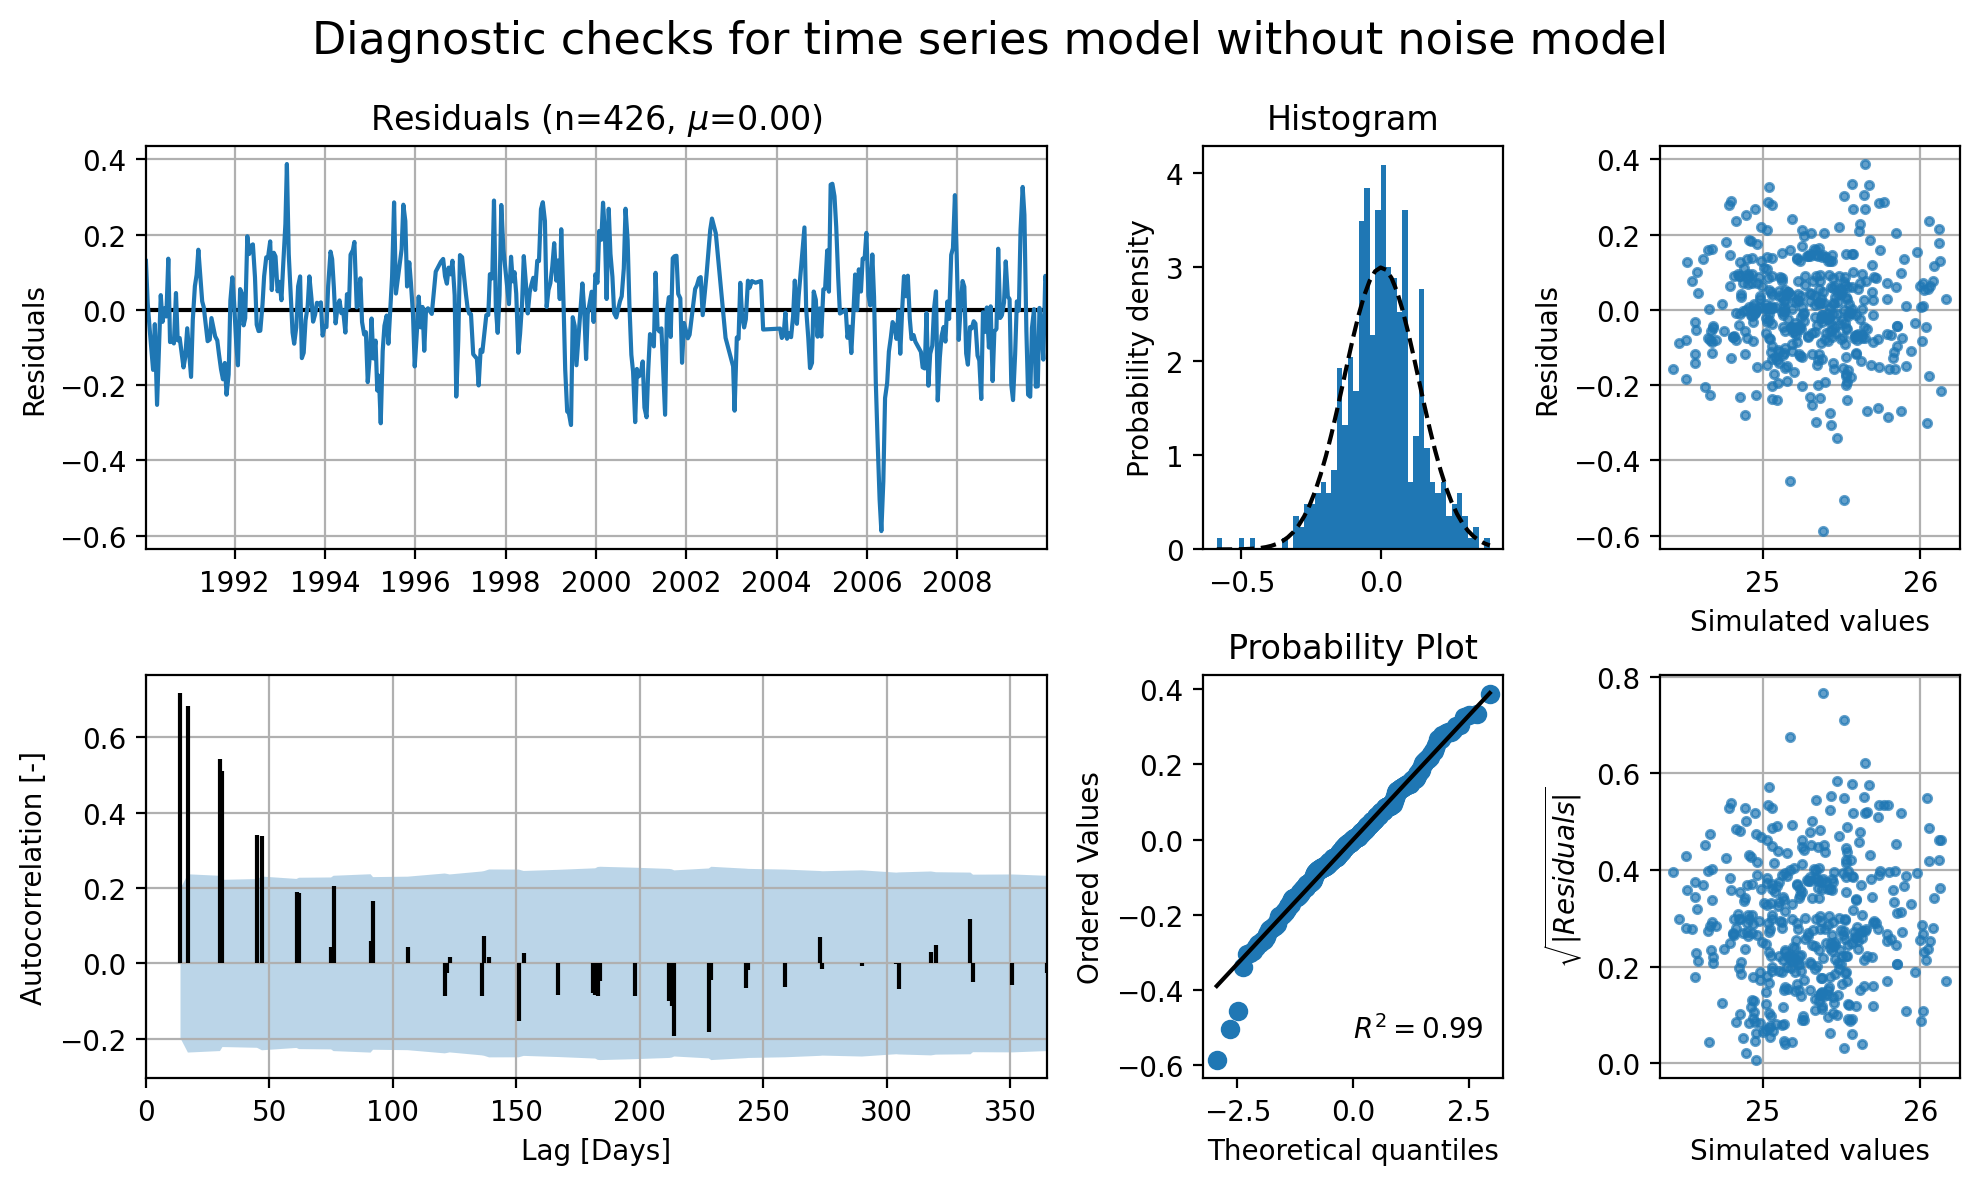

In [17]:
ml.plots.diagnostics(figsize=(10, 6))
fig = plt.gcf()
fig.suptitle(
    'Diagnostic checks for time series model without noise model', fontsize=16)
plt.tight_layout()

If we now once again create a time series model of the synthetic groundwater head series, but this time *include* a noise model, the fit is again good and the estimated parameters still closely match the specified parameters. However, now the autocorrelation of the noise is within the acceptable level — the noise model has done its job well.

The fit of the time series model with a noise model is always lower than that of a model without a noise model. However, in this case, the difference is small.


Estimated 95% confidence interval for a: 121.76 - 160.53


The figure layout has changed to tight

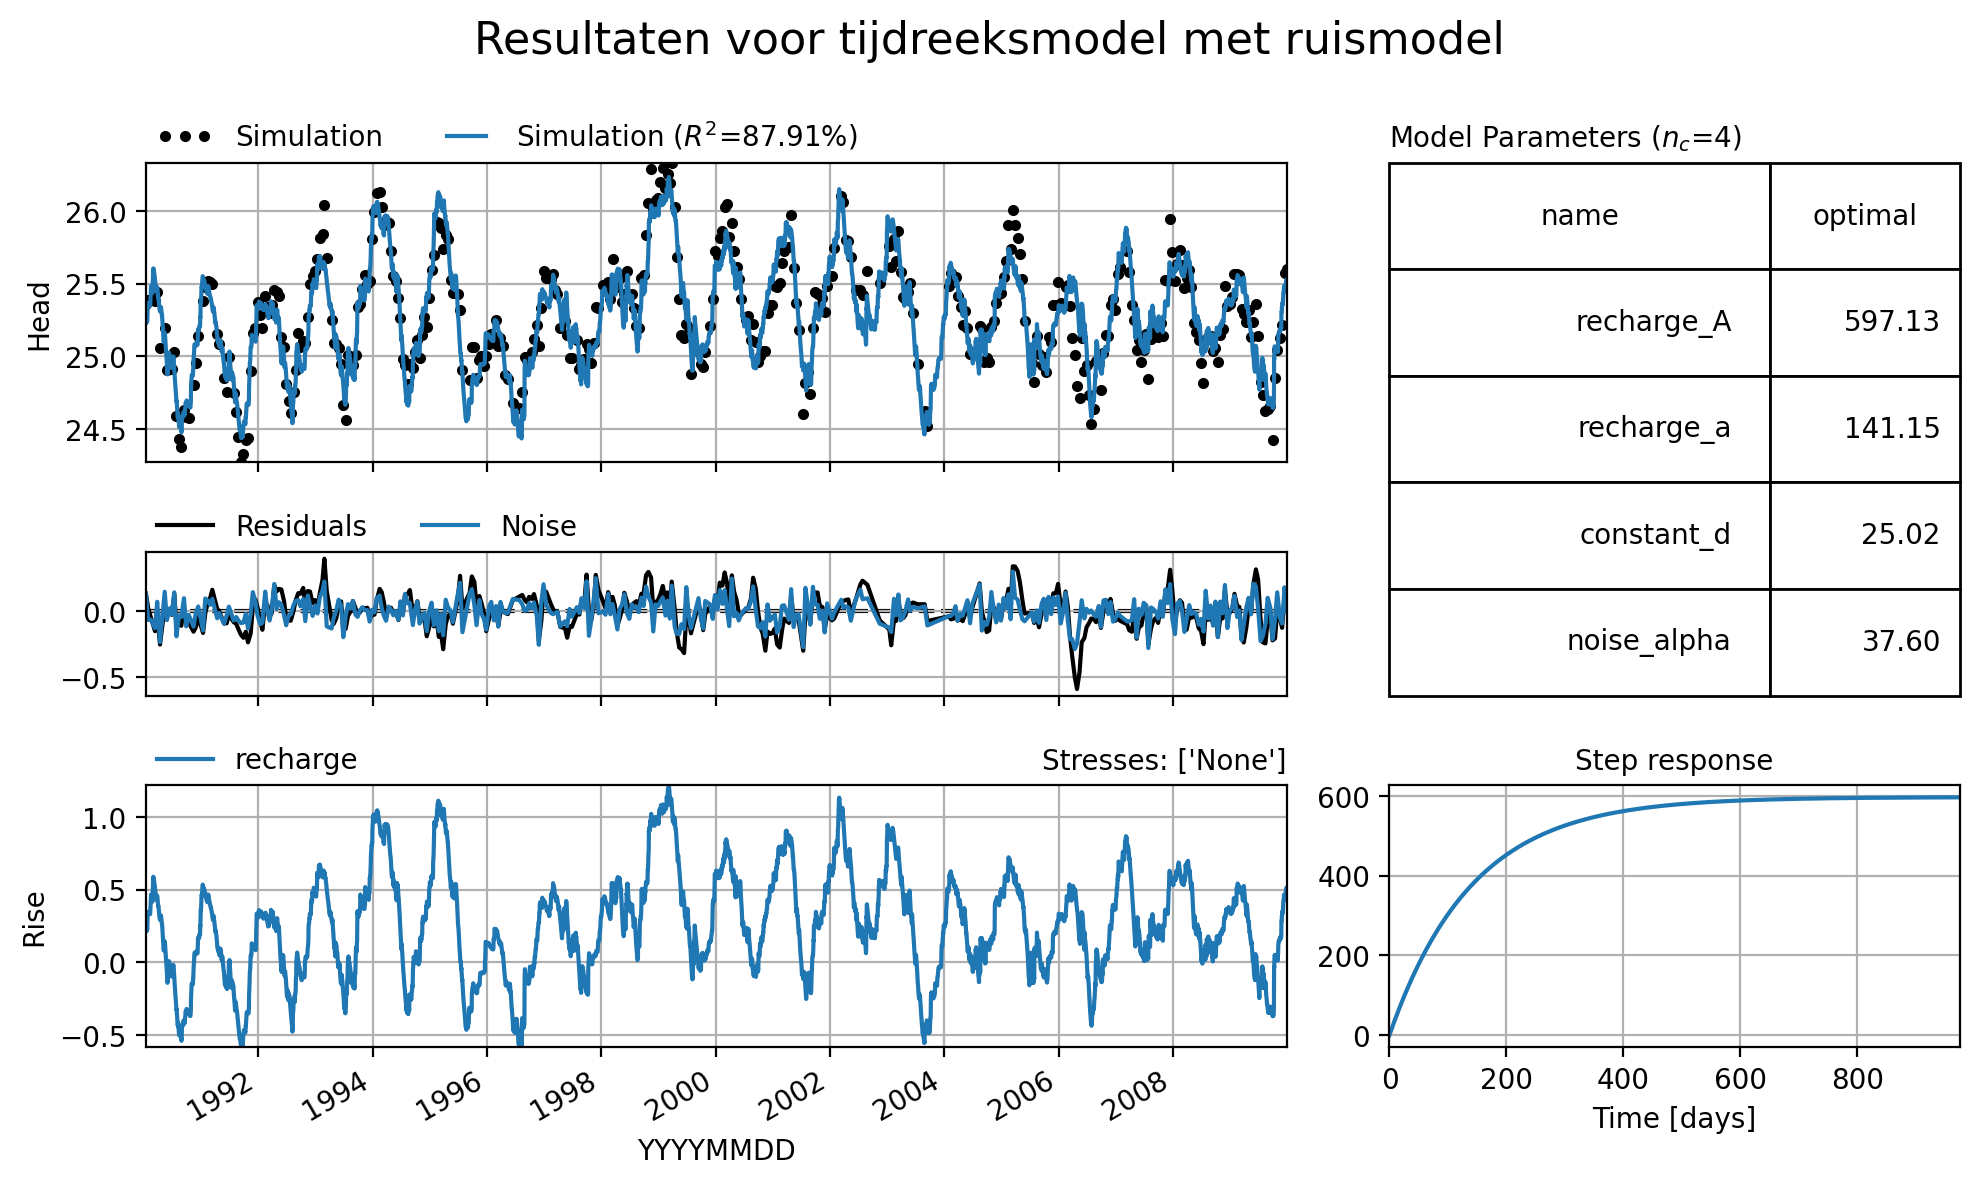

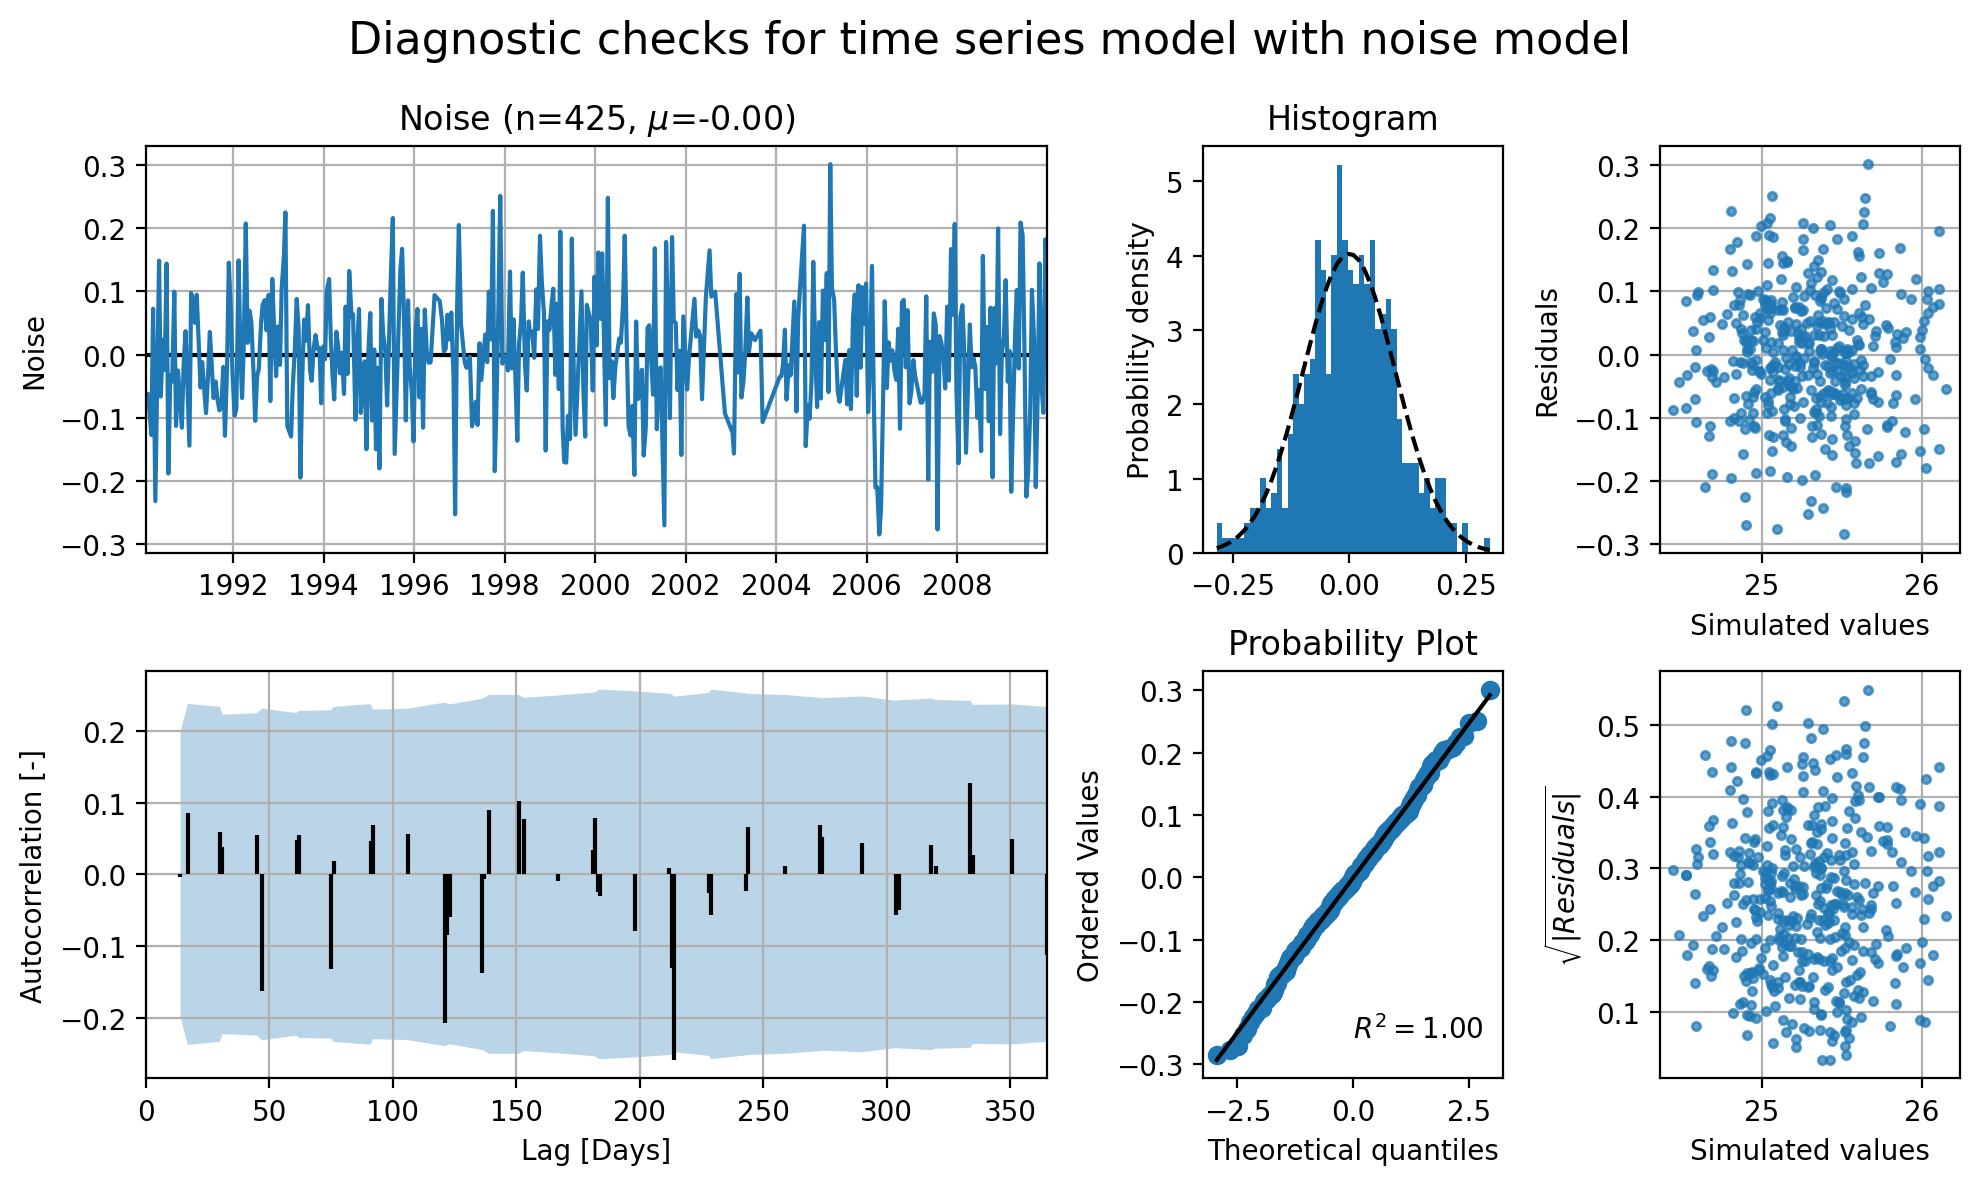

In [18]:
ml = ps.Model(hsynthetic)
rm = ps.StressModel(recharge, ps.Exponential(), name='recharge')
ml.add_stressmodel(rm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(report=False)
ml.plots.results(figsize=(10, 6))
fig = plt.gcf()
fig.suptitle('Resultaten voor tijdreeksmodel met ruismodel', fontsize=16)
plt.tight_layout()
#
a_min = ml.parameters.loc['recharge_a', 'optimal'] - \
    1.96 * ml.parameters.loc['recharge_a', 'stderr']
a_max = ml.parameters.loc['recharge_a', 'optimal'] + \
    1.96 * ml.parameters.loc['recharge_a', 'stderr']
print(f'Estimated 95% confidence interval for a: {a_min:.2f} - {a_max:.2f}')
#
ml.plots.diagnostics(figsize=(10, 6))
fig = plt.gcf()
fig.suptitle(
    'Diagnostic checks for time series model with noise model', fontsize=16)
plt.tight_layout()

## Effect of the noise model on the estimation and reliability of the parameters

If the noise model is not applied, the true value of $a$ does not fall within the estimated confidence interval. However, when the noise model *is* applied, the true value of $a$ *does* fall within the estimated confidence interval. 

Of course, this could be due to chance (after all, it's a 95% confidence interval, so there is a 5% chance that the true value falls outside it). That’s why we will perform an experiment.

In the experiment, we generate a synthetic series 100 times, each time with different (correlated) noise. For all 100 synthetic series, we create a time series model. Since the synthetic series contains different (correlated) noise each time, the optimal parameters vary slightly across the runs.

The experiment is conducted twice: the first time, 100 time series models are created *without* a noise model; the second time, 100 models are created *with* a noise model.


In [19]:
def experiment(nexp, sigma_noise=0.1, noisemodel=True):
    Aexp = np.zeros((nexp, 2))
    aexp = np.zeros((nexp, 2))
    dexp = np.zeros((nexp, 2))
    alphaexp = np.zeros((nexp, 2))
    evpexp = np.zeros(nexp)
    print('progress of experiment:')
    for iexp in range(nexp):
        if (iexp + 1) % 20 == 0:
            print(iexp + 1, end='%, ')
        np.random.seed(iexp)
        noise = sigma_noise * np.random.randn(len(ho))
        residuals = np.zeros_like(noise)
        residuals[0] = noise[0]
        for i in range(1, len(ho)):
            residuals[i] = np.exp(-delt[i - 1] / alpha) * \
                residuals[i - 1] + noise[i]
        hsynthetic = hsynthetic_no_error + residuals
        ml = ps.Model(hsynthetic)
        rm = ps.StressModel(recharge, ps.Exponential(), name='recharge')
        ml.add_stressmodel(rm)
        if noisemodel:
            ml.add_noisemodel(ps.ArNoiseModel()) 
        else:
            ml.del_noisemodel()
        ml.solve(report=False)
        Aexp[iexp] = ml.parameters.loc['recharge_A', ['optimal', 'stderr']]
        aexp[iexp] = ml.parameters.loc['recharge_a', ['optimal', 'stderr']]
        dexp[iexp] = ml.parameters.loc['constant_d', ['optimal', 'stderr']]
        if noisemodel:
            alphaexp[iexp] = ml.parameters.loc['noise_alpha',
                                               ['optimal', 'stderr']]
        evpexp[iexp] = ml.stats.evp()
    return Aexp, aexp, dexp, alphaexp, evpexp

In [20]:
result_no_noisemodel = experiment(100, noisemodel=False)

progress of experiment:
20%, 40%, 60%, 80%, 100%, 

In [21]:
print('Results without a noise model')
print(f'Mean value of parameter A: '
      f'{np.mean(result_no_noisemodel[0][:, 0]):.2f}')
print(f'Mean value of parameter a: '
      f'{np.mean(result_no_noisemodel[1][:, 0]):.2f}')
print(f'Mean value of parameter d: '
      f'{np.mean(result_no_noisemodel[2][:, 0]):.2f}')
print(f'Mean value of evp: {np.mean(result_no_noisemodel[4]):.2f}')

Results without a noise model
Mean value of parameter A: 602.81
Mean value of parameter a: 151.65
Mean value of parameter d: 25.00
Mean value of evp: 85.02


In [22]:
result_with_noisemodel = experiment(100, noisemodel=True)

progress of experiment:
20%, 40%, 60%, 80%, 100%, 

In [23]:
print('Results with a noise model')
print(f'Mean value of parameter A: '
      f'{np.mean(result_with_noisemodel[0][:, 0]):.2f}')
print(f'Mean value of parameter a: '
      f'{np.mean(result_with_noisemodel[1][:, 0]):.2f}')
print(f'Mean value of parameter d: '
      f'{np.mean(result_with_noisemodel[2][:, 0]):.2f}')
print(f'Mean value of parameter alpha: '
      f'{np.mean(result_with_noisemodel[3][:, 0]):.2f}')
print(f'Mean value of evp: '
      f'{np.mean(result_with_noisemodel[4]):.2f}')

Results with a noise model
Mean value of parameter A: 601.23
Mean value of parameter a: 151.30
Mean value of parameter d: 25.00
Mean value of parameter alpha: 45.91
Mean value of evp: 84.97


It turns out that both the time series model *without* the noise model and the model *with* the noise model give, on average, a good estimate of the parameters. So why should we use a noise model?

The reason is that the estimated uncertainty of the parameters is too small when no noise model is used. The statistical method used to estimate uncertainty assumes that the remaining noise (the residuals) is uncorrelated. However, if the noise is actually correlated, the estimated uncertainty is too small.

This can be easily verified with the experiment performed above. During the experiment, the parameters were estimated 100 times, each time including an estimate of the standard error. Under certain statistical assumptions (including normality and uncorrelated noise), the 95% confidence interval is calculated as the estimated value ± 2 times the standard error (technically 1.96, but we round to 2 here).

So it's easy to check how often the true parameter values (used to generate the synthetic series) fall within the 95% confidence intervals of the estimated parameters. Since we repeated the experiment 100 times, this should happen about 95 times.

As shown below, the time series model *without* a noise model only provides a confidence interval that contains the true value about 60–65 times. The model *with* a noise model performs much better: in more than 95 out of 100 cases, the true parameter values of the response functions lie within the 95% confidence interval.

In summary: without a noise model, the parameter estimates are on average correct, but the confidence intervals are too narrow (i.e., uncertainty is underestimated).


In [24]:
Aexp, aexp, dexp, alphaexp, evp = result_no_noisemodel
print('results without noise model')
print('number of times true A within estimated confidence interval:',
      np.count_nonzero(np.abs(Aexp[:, 0] - A) < 1.96 * Aexp[:, 1]))
print('number of times true a within estimated confidence interval:',
      np.count_nonzero(np.abs(aexp[:, 0] - a) < 1.96 * aexp[:, 1]))
print('number of times true d within estimated confidence interval:',
      np.count_nonzero(np.abs(dexp[:, 0] - d) < 1.96 * dexp[:, 1]))

results without noise model
number of times true A within estimated confidence interval: 65
number of times true a within estimated confidence interval: 69
number of times true d within estimated confidence interval: 57


In [25]:
Aexp, aexp, dexp, alphaexp, evp = result_with_noisemodel
print('results without noise model')
print('number of times true A within estimated confidence interval:',
      np.count_nonzero(np.abs(Aexp[:, 0] - A) < 1.96 * Aexp[:, 1]))
print('number of times true a within estimated confidence interval:',
      np.count_nonzero(np.abs(aexp[:, 0] - a) < 1.96 * aexp[:, 1]))
print('number of times true d within estimated confidence interval:',
      np.count_nonzero(np.abs(dexp[:, 0] - d) < 1.96 * dexp[:, 1]))
print('number of times true alpha within estimated confidence interval:',
      np.count_nonzero(np.abs(alphaexp[:, 0] - alpha) < 1.96 * alphaexp[:, 1]))

results without noise model
number of times true A within estimated confidence interval: 96
number of times true a within estimated confidence interval: 94
number of times true d within estimated confidence interval: 99
number of times true alpha within estimated confidence interval: 85


## Effect of an error in the measured groundwater recharge

The above experiment explained the advantage of using a noise model. When no noise model is used, the parameters are estimated correctly, but the confidence intervals are too narrow. When a noise model *is* included, the confidence intervals are estimated much more accurately.

In the previous example, the noise in the groundwater head was generated using a model that was exactly the same as the noise model used in the time series model. As previously explained, the correlation in the residuals in reality is the result of physical processes — for example, a difference between the rainfall measured at the weather station and the rainfall that actually occurred at the observation well.

In the following test, the experiment is repeated, but this time a correlated error is *not* added to the groundwater head. Instead, a groundwater recharge series (rainfall minus evaporation) is used that contains an error.

There are many ways to add a realistic error to rainfall or evaporation series. Here, we choose to multiply the measured groundwater recharge by a factor $(1 + \varepsilon_g)$, where $\varepsilon_g$ is normally distributed with a mean of zero and a standard deviation of $\sigma_g$. This means that the groundwater recharge is slightly higher or lower than measured on each day. The chosen value for $\sigma_g$ is 0.2.

Below, a time series model is created in which an AR(1) noise model is again included in the fit. As can be seen, the fit is very good and there is virtually no autocorrelation in the noise. However, the noise is not very normally distributed. This is concerning, because the estimation of the confidence intervals for the parameters assumes that the noise is normally distributed.


The figure layout has changed to tight

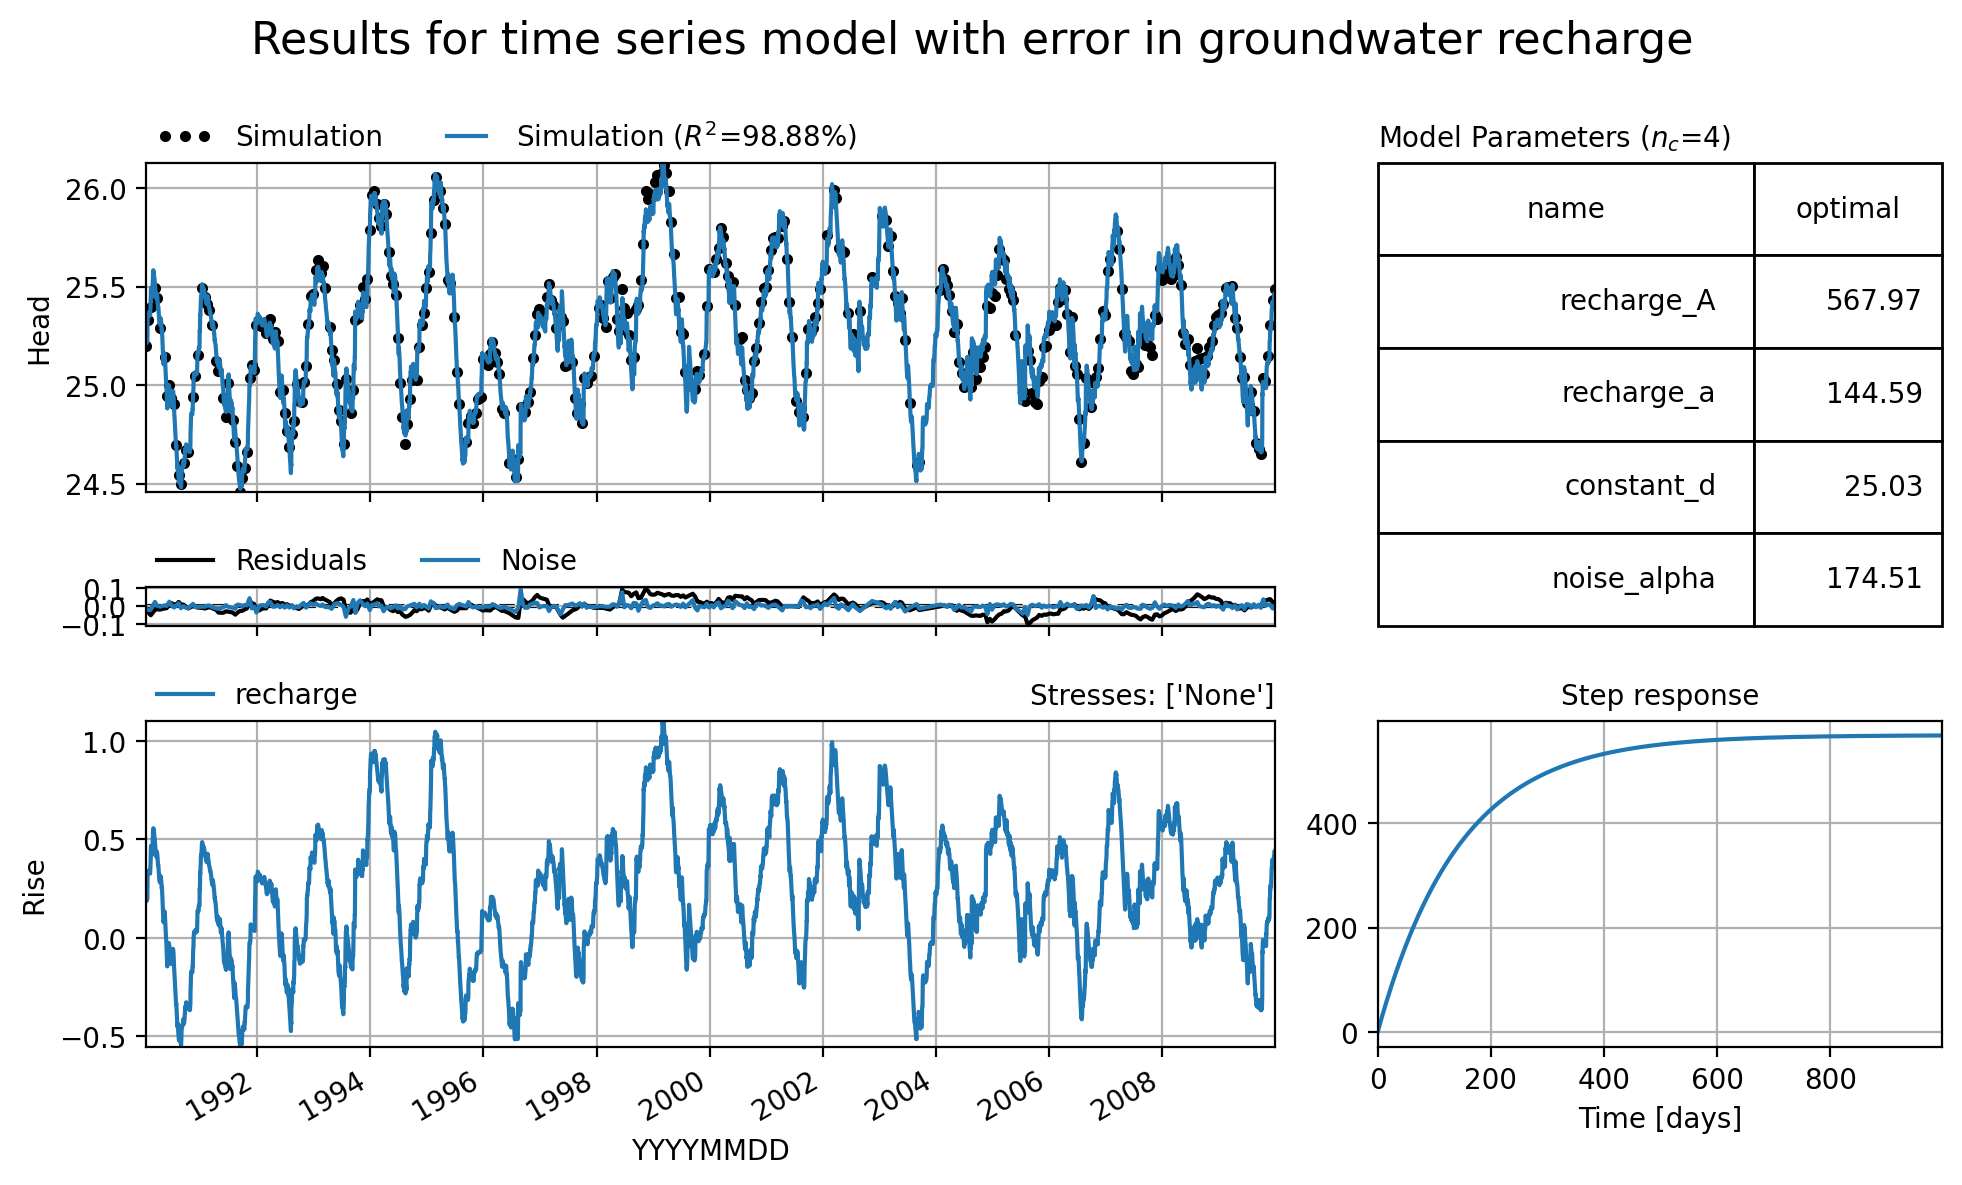

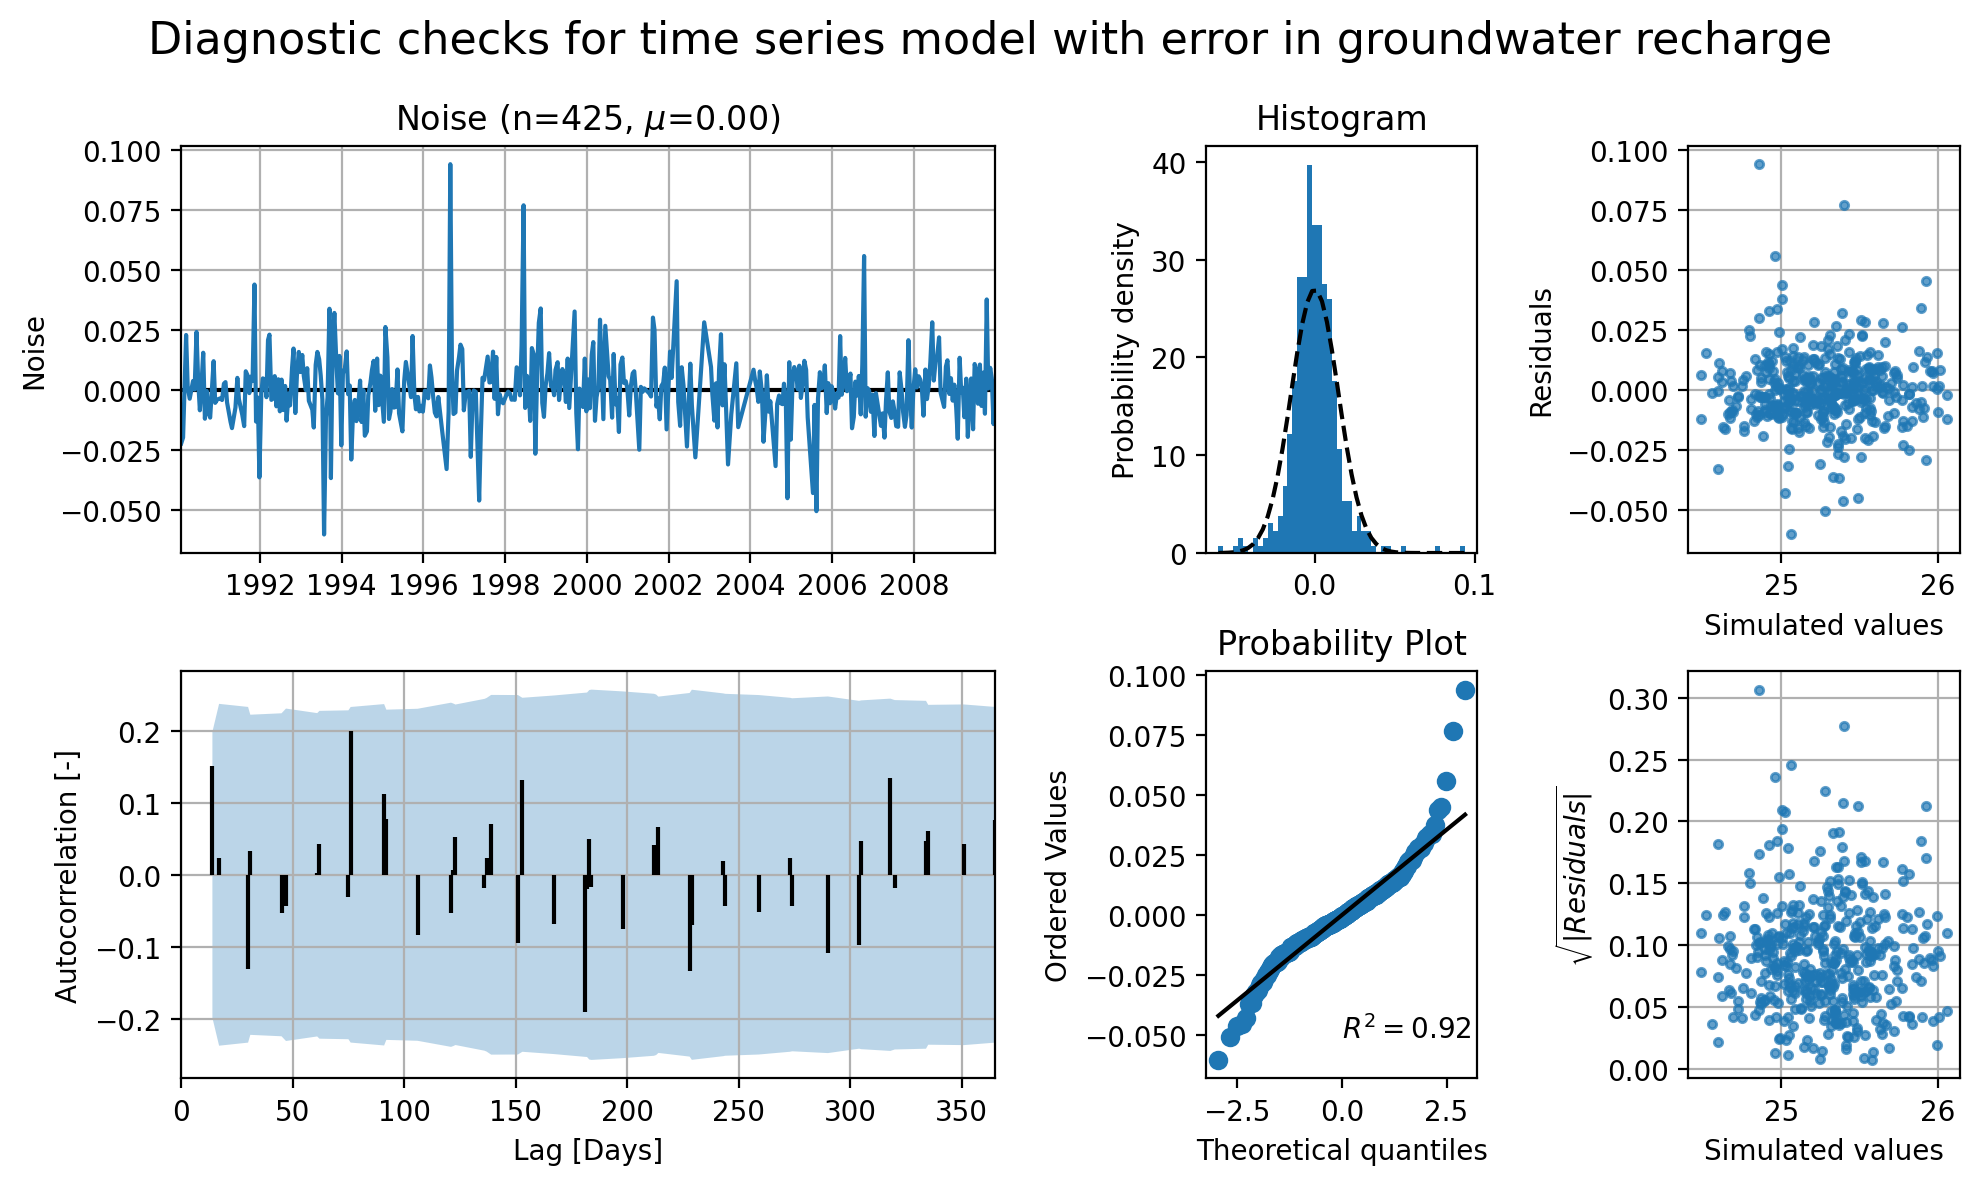

In [26]:
np.random.seed(100)
factor = 1 + 0.2 * np.random.randn(len(recharge))
ml = ps.Model(hsynthetic_no_error)
rm = ps.StressModel(factor * recharge, ps.Exponential(), name='recharge')
ml.add_stressmodel(rm)
ml.add_noisemodel(ps.ArNoiseModel()) 
ml.solve(report=False)
#
ml.plots.results(figsize=(10, 6))
fig = plt.gcf()
fig.suptitle(
    'Results for time series model with error in groundwater recharge', fontsize=16)
plt.tight_layout()
ml.plots.diagnostics(figsize=(10, 6))
fig = plt.gcf()
fig.suptitle(
    'Diagnostic checks for time series model with error in groundwater recharge', fontsize=16)
plt.tight_layout()

We will once again perform the experiment described above. The time series models *without* a noise model again estimate the parameters well on average, but the confidence intervals are far too narrow: in only 30–40% of the models do the true parameters fall within the confidence intervals of the estimated parameters.

The time series models *with* a noise model also produce good results for the estimated parameters. In 80–85% of the models, the true parameters fall within the confidence intervals of the estimated parameters. This is less than the expected 95% and is most likely due to the noise not being normally distributed.

To improve this, a time series model should ideally be used that is based on, for example, a maximum likelihood estimation of the parameters, where the expected distribution of the noise can be specified (see for example van der Spek and Bakker, 2017). However, in most current versions of time series analysis software, it is not possible to define a custom maximum likelihood function.


In [27]:
def experiment(nexp, sigma_noise=0.1, noisemodel=True):
    Aexp = np.zeros((nexp, 2))
    aexp = np.zeros((nexp, 2))
    dexp = np.zeros((nexp, 2))
    alphaexp = np.zeros((nexp, 2))
    evpexp = np.zeros(nexp)
    print('progress of experiment:')
    for iexp in range(nexp):
        if (iexp + 1) % 20 == 0:
            print(iexp + 1, end='%, ')
        np.random.seed(iexp)
        factor = 1 + 0.2 * np.random.randn(len(recharge))
        ml = ps.Model(hsynthetic_no_error)
        rm = ps.StressModel(factor * recharge, ps.Exponential(), name='recharge')
        ml.add_stressmodel(rm)
        if noisemodel:
            ml.add_noisemodel(ps.ArNoiseModel()) 
        else:
            ml.del_noisemodel()
        ml.solve(report=False)
        Aexp[iexp] = ml.parameters.loc['recharge_A', ['optimal', 'stderr']]
        aexp[iexp] = ml.parameters.loc['recharge_a', ['optimal', 'stderr']]
        dexp[iexp] = ml.parameters.loc['constant_d', ['optimal', 'stderr']]
        if noisemodel:
            alphaexp[iexp] = ml.parameters.loc['noise_alpha',
                                               ['optimal', 'stderr']]
        evpexp[iexp] = ml.stats.evp()
    return Aexp, aexp, dexp, alphaexp, evpexp

In [28]:
result_no_noisemodel = experiment(100, noisemodel=False)

progress of experiment:
20%, 40%, 60%, 80%, 100%, 

In [29]:
result_with_noisemodel = experiment(100, noisemodel=True)

progress of experiment:
20%, 40%, 60%, 80%, 100%, 

In [30]:
print('Results of models with error in recharge, without a noise model')
print('Mean value of parameter A:'
      f' {np.mean(result_no_noisemodel[0][:, 0]):.2f}')
print('Mean value of parameter a: '
      f'{np.mean(result_no_noisemodel[1][:, 0]):.2f}')
print(f'Mean value of parameter d: '
      f'{np.mean(result_no_noisemodel[2][:, 0]):.2f}')
print(f'Mean value of evp: {np.mean(result_no_noisemodel[4]):.2f}')

Results of models with error in recharge, without a noise model
Mean value of parameter A: 591.70
Mean value of parameter a: 149.22
Mean value of parameter d: 25.00
Mean value of evp: 99.17


In [31]:
Aexp, aexp, dexp, alphaexp, evp = result_no_noisemodel
print('number of times true A within estimated confidence interval:',
      np.count_nonzero(np.abs(Aexp[:, 0] - A) < 1.96 * Aexp[:, 1]))
print('number of times true a within estimated confidence interval:',
      np.count_nonzero(np.abs(aexp[:, 0] - a) < 1.96 * aexp[:, 1]))
print('number of times true d within estimated confidence interval:',
      np.count_nonzero(np.abs(dexp[:, 0] - d) < 1.96 * dexp[:, 1]))

number of times true A within estimated confidence interval: 36
number of times true a within estimated confidence interval: 39
number of times true d within estimated confidence interval: 32


In [32]:
print('Results of models with error in recharge, with a noise model')
print(f'Mean value of parameter A: '
      f'{np.mean(result_with_noisemodel[0][:, 0]):.2f}')
print(f'Mean value of parameter a: '
      f'{np.mean(result_with_noisemodel[1][:, 0]):.2f}')
print(f'Mean value of parameter d: '
      f'{np.mean(result_with_noisemodel[2][:, 0]):.2f}')
print(f'Mean value of parameter alpha: '
      f'{np.mean(result_with_noisemodel[3][:, 0]):.2f}')
print(f'Mean value of evp: '
      f'{np.mean(result_with_noisemodel[4]):.2f}')

Results of models with error in recharge, with a noise model
Mean value of parameter A: 593.73
Mean value of parameter a: 150.51
Mean value of parameter d: 25.00
Mean value of parameter alpha: 142.86
Mean value of evp: 99.16


In [33]:
Aexp, aexp, dexp, alphaexp, evp = result_with_noisemodel
print('number of times true A within estimated confidence interval:',
      np.count_nonzero(np.abs(Aexp[:, 0] - A) < 1.96 * Aexp[:, 1]))
print('number of times true a within estimated confidence interval:',
      np.count_nonzero(np.abs(aexp[:, 0] - a) < 1.96 * aexp[:, 1]))
print('number of times true d within estimated confidence interval:',
      np.count_nonzero(np.abs(dexp[:, 0] - d) < 1.96 * dexp[:, 1]))
#print('number of times true alpha within estimated confidence interval:', np.count_nonzero(np.abs(alphaexp[:, 0] - alpha) < 1.96 * alphaexp[:, 1]))

number of times true A within estimated confidence interval: 83
number of times true a within estimated confidence interval: 79
number of times true d within estimated confidence interval: 83


## Effect of measurement frequency on the performance of the AR(1) noise model

It is often difficult, with current algorithms, to transform the residuals into noise with negligible autocorrelation for time series models of groundwater heads that are measured daily. A practical solution can be to reduce the measurement frequency — for example, by using only one measurement every week or every two weeks.

Consider, for example, observation well B16G0187_2 in the village of Witte Paarden in Steenwijkerland. The groundwater head was measured daily between 2005 and 2018. A time series model using rainfall and potential evaporation provides a good fit (see below), but there is still a clear autocorrelation in the residuals.


In [34]:
ho_df = pd.read_csv('data/B16G0187_2.csv', parse_dates=[0], index_col=0)
rain_df = pd.read_csv('data/Frederiksoord.csv', parse_dates=[0], index_col=0)
evap_df = pd.read_csv('data/Marknesse.csv', parse_dates=[0], index_col=0)


ho = ho_df.iloc[:, 0]
rain = rain_df.iloc[:, 0]
evap = evap_df.iloc[:, 0]

Fit report B16G0187_2              Fit Statistics
nfev    30                     EVP          86.78
nobs    4744                   R2            0.87
noise   True                   RMSE          0.07
tmin    2005-01-01 00:00:00    AICc     -30474.93
tmax    2018-04-04 00:00:00    BIC      -30436.16
freq    D                      Obj           3.84
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (6 optimized)
                optimal     initial  vary
recharge_A   324.802849  202.753032  True
recharge_n     1.161760    1.000000  True
recharge_a   128.227429   10.000000  True
recharge_f    -0.986534   -1.000000  True
constant_d    -0.666380   -0.419248  True
noise_alpha    4.275738    1.000000  True

Warnings! (1)
Response tmax for 'recharge' > than warmup period.


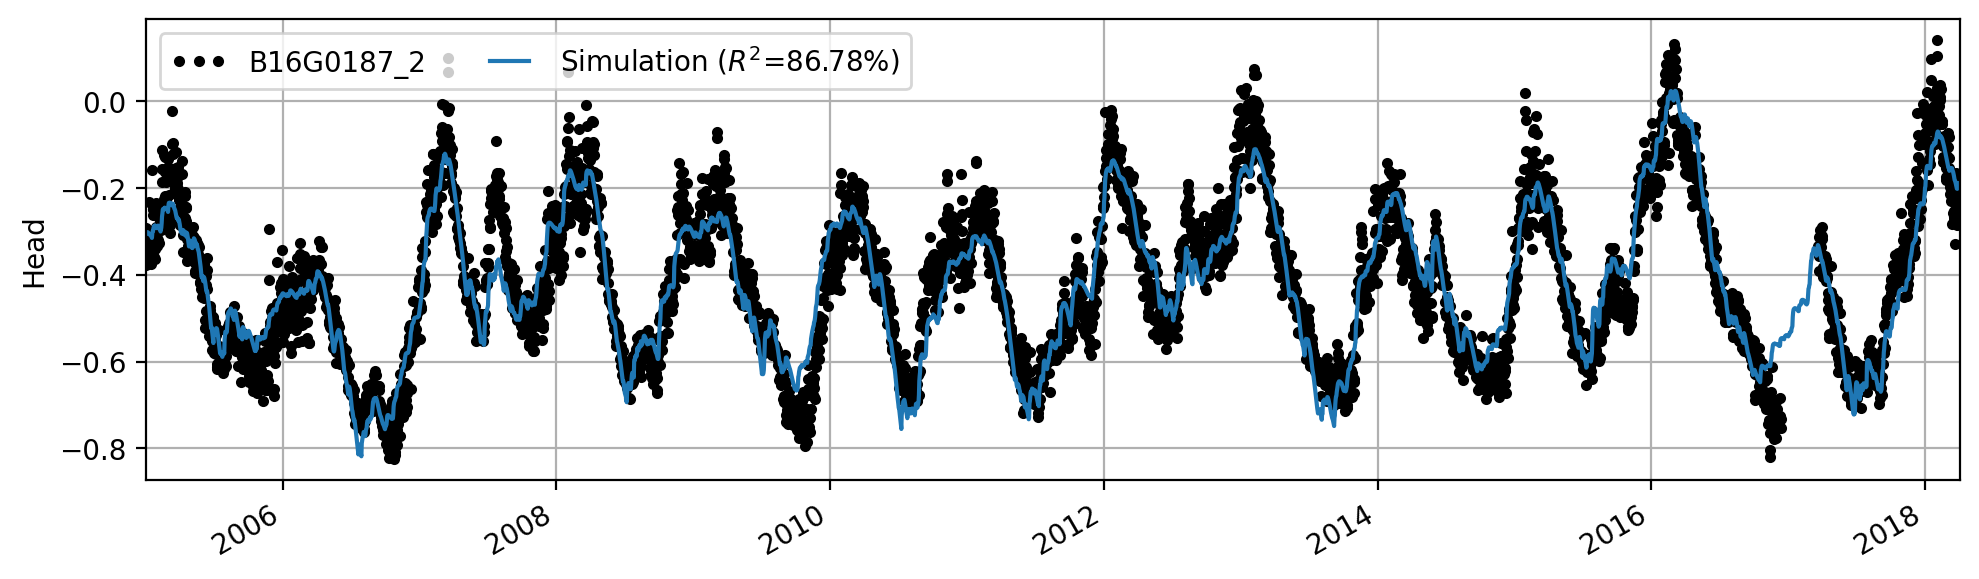

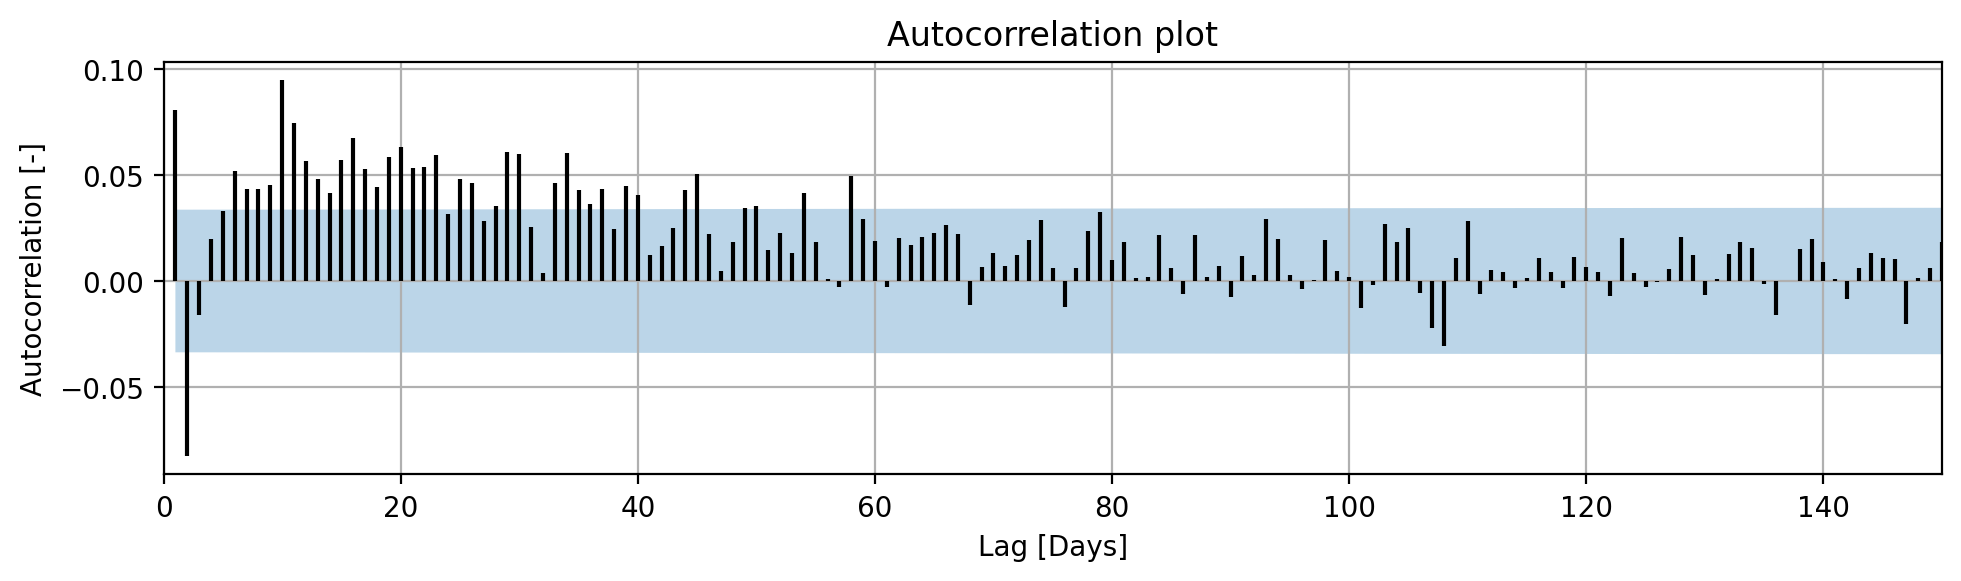

In [35]:
ml = ps.Model(ho)
rm = ps.RechargeModel(rain, evap, ps.Gamma(), name='recharge')
ml.add_stressmodel(rm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve()
ax = ml.plot(figsize=(10, 3))
ax.grid()
ax = ps.plots.acf(ml.noise(), figsize=(10, 3), alpha=0.05)
ax.set_xlim(0, 150)
plt.tight_layout()

The time series model was then fitted again, but this time using only 14-day interval measurements. As a result, the number of observations used for fitting was reduced from more than 4,500 to fewer than 400. The fit is approximately equally good, and all model parameters are similar — except for the parameter $\alpha$ of the noise model, which is now five times larger. 

However — and this was the goal — the autocorrelation in the noise is now negligible. This means that the standard errors (`stderr`) of the parameters can be used to estimate the confidence intervals of the parameters (provided that the other statistical assumptions are also met).

Note also that for this well, the standard error of the parameters in the model fitted to 14-day measurements is about twice as large for most parameters compared to the model fitted to daily measurements.


Fit report B16G0187_2             Fit Statistics
nfev    14                     EVP         86.99
nobs    339                    R2           0.87
noise   True                   RMSE         0.07
tmin    2005-01-01 00:00:00    AICc     -1949.29
tmax    2018-03-24 00:00:00    BIC      -1926.59
freq    D                      Obj          0.52
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (6 optimized)
                optimal     initial  vary
recharge_A   311.113221  202.753032  True
recharge_n     1.282128    1.000000  True
recharge_a   104.497756   10.000000  True
recharge_f    -0.947279   -1.000000  True
constant_d    -0.678718   -0.420647  True
noise_alpha   22.394017   14.000000  True

Warnings! (1)
Response tmax for 'recharge' > than warmup period.


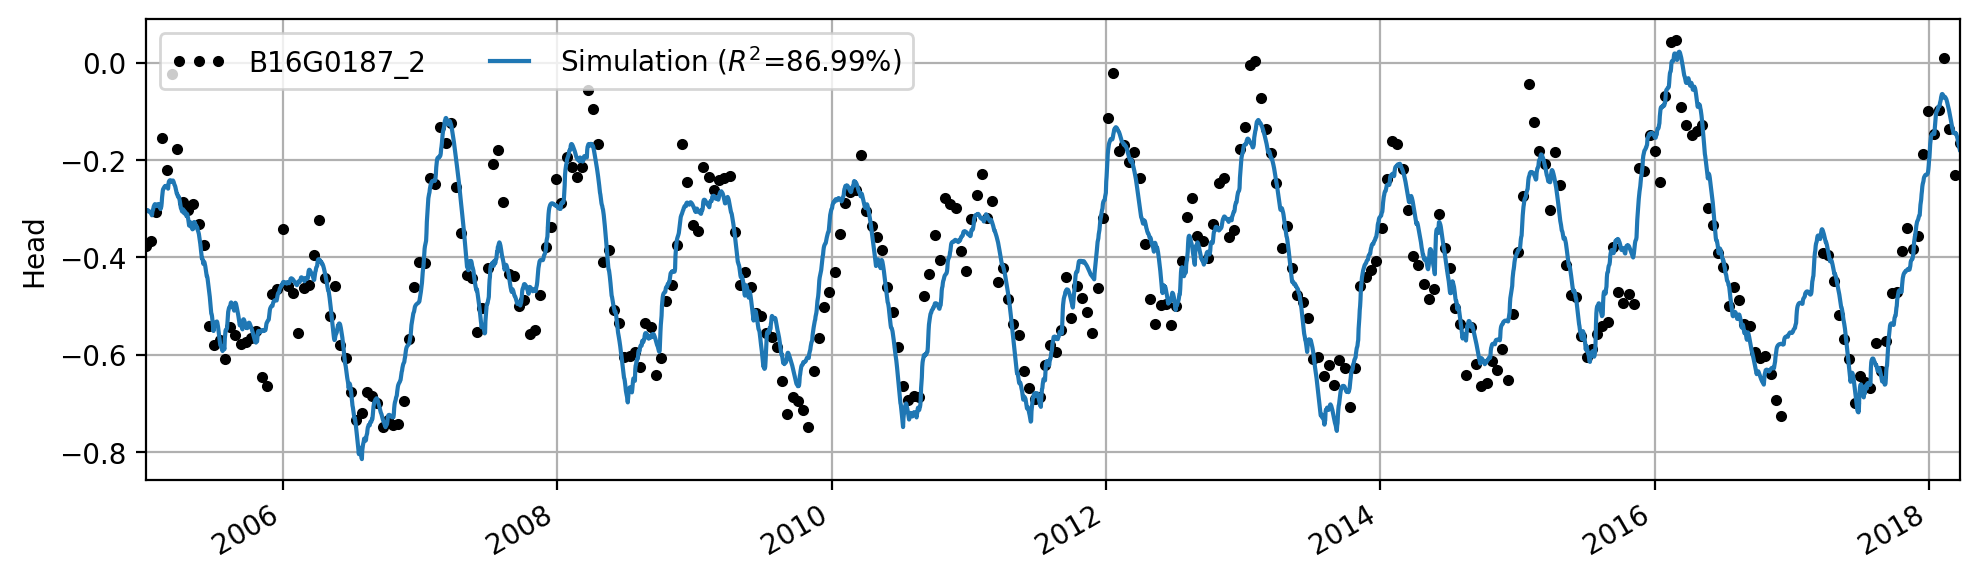

In [36]:
ml = ps.Model(ho.iloc[::14])
rm = ps.RechargeModel(rain, evap, ps.Gamma(), name='recharge')
ml.add_stressmodel(rm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve()
ax = ml.plot(figsize=(10, 3))
ax.grid()

## References

- J.E. van der Spek and M. Bakker, 2017. *The influence of the length of the calibration period and observation frequency on predictive uncertainty in time series modeling of groundwater dynamics*. Water Resources Research, 53(3), pp.2294–2311.